# London Postcode Investment Analysis

## Install Packages

In [1]:
pip install pmdarima

  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.1
    Uninstalling numpy-1.20.1:
      Successfully uninstalled numpy-1.20.1
Note: you may need to restart the kernel to use updated packages.


In [241]:
pip install descartes

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from pmdarima.metrics import smape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
%matplotlib inline
import pickle
import geopandas as gpd
import folium
import folium.plugins as plugins


# Project Overview

The aim of this project is to forecast the average house price in London postcodes with the aim of providing recommendations for new property buyers who want to grow what is usually the biggest investment we all make in our lives.

If you are one of the below, this product would be useful to you:
- Investors
- Any home buyer
- Emigrating to London 

The main purpose of this project is to forecast in the long term (5 years) and will not aim to predict short term highs and lows in the property market which would be beyond the scope of this project.

# Import the Data

As the datasets were so large, it took time to download and the website would regularly time out when trying to run large queries. As a result I downloaded the data in time segments. I will now put them all together.

There is a separate data set which has average prices through time for London Boroughs which I will also load for some EDA. This data came from the same source (Land Registry)

In [4]:
df2000_2002 = pd.read_csv('2000_2002.csv')
df2002_2006 = pd.read_csv('2002_2006.csv')
df2006_2011 = pd.read_csv('2006_2011.csv')
df2011_2016 = pd.read_csv('2011_2016.csv')
df2016_2021 = pd.read_csv('2016_2021.csv')

create a list of the dfs, this may be useful to explore the datasets and ensure I can append them.

In [5]:
dfs = [df2016_2021, df2011_2016, df2006_2011, df2002_2006, df2000_2002]

for df in dfs:
    print(df.shape)

(338887, 16)
(340644, 16)
(350267, 16)
(367691, 16)
(192195, 16)


great, it looks like there are equal number of columns in each dataframe, this should make adding them together relatively simple. 

In [6]:
df2002_2006.head()

unique_id  price_paid   deed_date postcode  \
0  3A04074C-AC1A-46D7-BD91-FBF7501BAD44      173500  28/10/2004   E1 0AE   
1  262FFF4F-0AFC-469E-9C41-BC09FE43F210      171000  16/08/2005   E1 0AE   
2  D3B8DD42-1C71-4551-ACB9-A4C04126AEE7      177000  25/10/2004   E1 0AE   
3  6DA08449-D140-30F2-E053-6B04A8C05F3B      157500  06/02/2003   E1 0AE   
4  261DD75C-2E11-46D7-83AF-C35B100F1B4E      169000  01/07/2004   E1 0AE   

  property_type new_build estate_type saon paon        street locality  \
0             F         N           L  NaN  324  CABLE STREET   LONDON   
1             F         N           L  NaN  326  CABLE STREET   LONDON   
2             F         N           L  NaN  330  CABLE STREET   LONDON   
3             F         N           L  NaN  332  CABLE STREET      NaN   
4             F         N           L  NaN  340  CABLE STREET   LONDON   

     town       district          county transaction_category  \
0  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

In [7]:
df2006_2011.head()

unique_id  price_paid   deed_date postcode  \
0  DF33AD88-E093-4796-B42C-9A10B910D743      115500  16/03/2007   E1 0AD   
1  00E7F6C2-3F26-4123-8475-FA697F239A09      105000  16/03/2007   E1 0AD   
2  8A87041C-93CB-497A-B8E6-56FFEE2552E3      102000  12/03/2007   E1 0AD   
3  35CDF0A7-1550-4555-801A-46DDC0B7171A      150000  11/05/2007   E1 0AD   
4  9021C9C5-FCCD-4203-B43A-2E8BDBA322E0       97500  15/03/2007   E1 0AD   

  property_type new_build estate_type    saon                  paon  \
0             F         Y           L  FLAT 4  BILL FAUST HOUSE, 20   
1             F         Y           L  FLAT 5  BILL FAUST HOUSE, 20   
2             F         Y           L  FLAT 8  BILL FAUST HOUSE, 20   
3             F         Y           L  FLAT 9  BILL FAUST HOUSE, 20   
4             F         N           L  FLAT 1  ADAM MEERE HOUSE, 24   

           street locality    town       district          county  \
0  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
3  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   
4  TARLING STREET   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [8]:
df2011_2016.head()

unique_id  price_paid   deed_date postcode  \
0  CFC960FB-CFB4-4CFB-BDF5-138EF6ECB21B      129500  27/05/2011   E1 0AD   
1  6ADB7B46-76D2-4FB8-BA12-DEEECB58CEB2      270000  08/07/2014   E1 0AD   
2  4123F148-7A6C-4A7D-BBBF-739540D9F688      210000  01/12/2011   E1 0AD   
3  2479F407-6623-4468-B4EE-436C7F00E0C7      250000  17/06/2011   E1 0AD   
4  1570B1D0-C6DD-4B0C-9645-2B3D3A934C8C      249995  29/06/2012   E1 0AE   

  property_type new_build estate_type    saon                  paon  \
0             F         N           L  FLAT 4  BILL FAUST HOUSE, 20   
1             F         N           L  FLAT 8  BILL FAUST HOUSE, 20   
2             F         N           L  FLAT 8  ADAM MEERE HOUSE, 24   
3             F         N           L  FLAT 9  ADAM MEERE HOUSE, 24   
4             F         N           L     NaN                   296   

           street locality    town       district          county  \
0  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
3  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
4    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [9]:
df2016_2021.head()

unique_id  price_paid   deed_date postcode  \
0  8A78B2AF-785C-5CB0-E053-6B04A8C0F504      140000  24/05/2019   E1 0AD   
1  B0A9D11B-5E60-4C1F-E053-6C04A8C0D716      325000  13/08/2020   E1 0AD   
2  8355F008-E752-55C5-E053-6B04A8C0D090      176000  06/12/2018   E1 0AD   
3  4E95D758-19CD-EDA1-E050-A8C0630539E2      450000  31/03/2017   E1 0AE   
4  5376B385-4F7D-34C1-E053-6B04A8C09FF6      440000  23/05/2017   E1 0AE   

  property_type new_build estate_type    saon                  paon  \
0             F         N           L  FLAT 6  BILL FAUST HOUSE, 20   
1             F         N           L  FLAT 8  BILL FAUST HOUSE, 20   
2             F         N           L  FLAT 5  ADAM MEERE HOUSE, 24   
3             F         N           L     NaN                   296   
4             F         N           L     NaN                   314   

           street locality    town       district          county  \
0  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
1  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
2  TARLING STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
3    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
4    CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   

  transaction_category                                        linked_data  
0                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
1                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
2                    A  http://landregistry.data.gov.uk/data/ppi/trans...  
3                    B  http://landregistry.data.gov.uk/data/ppi/trans...  
4                    A  http://landregistry.data.gov.uk/data/ppi/trans...

In [10]:
df2000_2002.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

all the columns are the same, these dataframes can just be appended. 

In [11]:
new = df2000_2002.append(df2002_2006)
new = new.append(df2006_2011)
new = new.append(df2011_2016)
new = new.append(df2016_2021)
new.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data  
0  http://landregistry.data.gov.uk/data/ppi/trans...  
1  http://landregistry.data.gov.uk/data/ppi/trans...  
2  http://landregistry.data.gov.uk/data/ppi/trans...  
3  http://landregistry.data.gov.uk/data/ppi/trans...  
4  http://landregistry.data.gov.uk/data/ppi/trans...

In [12]:
new.shape

(1589684, 16)

This has been successful, I will now continue with data cleaning and inspection, first though, a description of what these features mean and are they important i.e can I drop them now?

 - unique_id: this is just the id number for the transaction
 - price_paid: In Pound Sterling
 - deed_date: date of completion
 - property_type: detached, semi-detached, terraced or flat maissonette
 - new_build: yes or no
 - estate_type: leasehold or freehold
 - saon: secondary addressable object name, if there is a building that is subdivided into flats for example, there will be an saon.
 - paon: primary addressable object name (typically the house number or name)
 - street: street name
 - locality: in this instance will be London
 - town: if applicable, more granular detail than London could be given
 - district: should represent the Borough.
 - county: greater london in this project
 - transaction_category: standard or additional
 - linked_data: url to transaction information

It looks like many of these columns can be dropped as they will not be particularly useful and the information is often provided in another feature. For example locality and town are similar. Before dropping, I will check for duplicates and null values

In [13]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
3968
property_type
0
new_build
0
estate_type
0
saon
892587
paon
18
street
858
locality
895989
town
0
district
0
county
0
transaction_category
0
linked_data
0


Since I want to ensure I have captured all of the Boroughs, I will do some EDA on this feature now. 

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

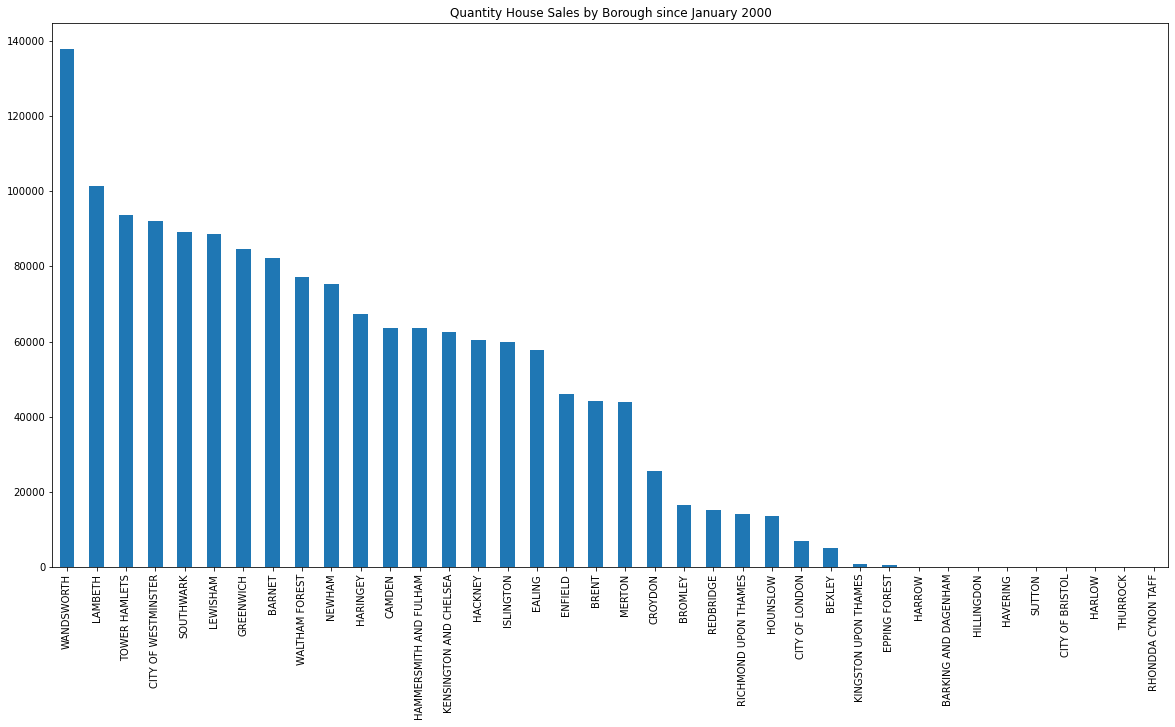

In [14]:
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

It appears that there are some Boroughs that have not been well captured by my initial search. I will run another query for these Boroughs separately and append this data. It is important to capture as much data as possible, but if there is sufficient data for a given Borough I will not re-run the query for it indivually (i.e Wandsworth) 

Another thing, are all of these actually Boroughs of London? No.

There are 32 local authority boroughs in London, plus the City of London which provides the same services as a Borough but to a much smaller area. For the purposes of this project, I will be treating the City of London as a Borough.

In [15]:
boroughs = [
        'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent',
        'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
        'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
        'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
        'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
        'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
        'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster', 'City of London'
    ]

for i in range(len(boroughs)):
    boroughs[i] = boroughs[i].lower()

boroughs


['barking and dagenham',
 'barnet',
 'bexley',
 'brent',
 'bromley',
 'camden',
 'croydon',
 'ealing',
 'enfield',
 'greenwich',
 'hackney',
 'hammersmith and fulham',
 'haringey',
 'harrow',
 'havering',
 'hillingdon',
 'hounslow',
 'islington',
 'kensington and chelsea',
 'kingston upon thames',
 'lambeth',
 'lewisham',
 'merton',
 'newham',
 'redbridge',
 'richmond upon thames',
 'southwark',
 'sutton',
 'tower hamlets',
 'waltham forest',
 'wandsworth',
 'westminster',
 'city of london']

In [16]:
for i in new['district'].unique():
    i = i.lower()
    if i not in boroughs:
        print(i)

epping forest
city of westminster
thurrock
rhondda cynon taff
harlow
city of bristol


In [17]:
# change the name of city of westminster to westminster
new['district'] = new['district'].replace('CITY OF WESTMINSTER', 'WESTMINSTER')

In [18]:
not_boroughs = []
for i in new['district'].unique():
    
    i = i.lower()
    if i not in boroughs:
        not_boroughs.append(i.upper())
        print(i)

epping forest
thurrock
rhondda cynon taff
harlow
city of bristol


In [19]:
not_boroughs

['EPPING FOREST',
 'THURROCK',
 'RHONDDA CYNON TAFF',
 'HARLOW',
 'CITY OF BRISTOL']

I will delete these entries from the dataset.

In [20]:
# remove rows with district values that are not boroughs
new = new[~new['district'].isin(not_boroughs)]



In [21]:
for i in new['district'].unique():
    i = i.lower()
    if i not in boroughs:
        print(i)

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

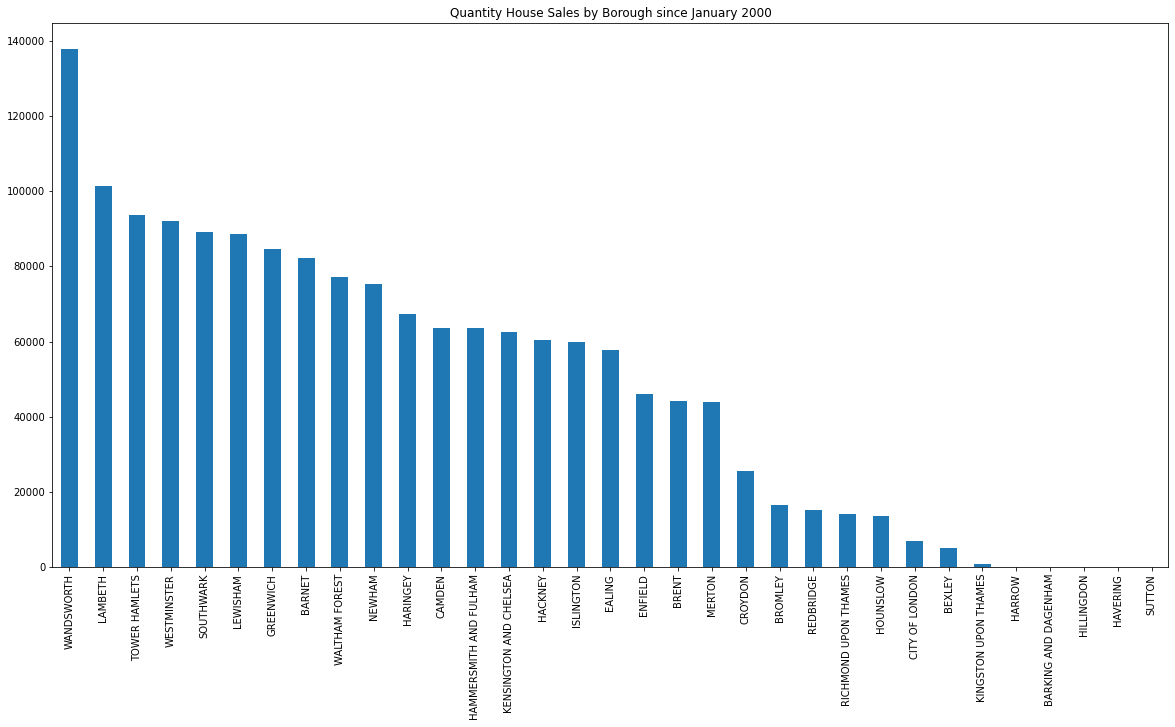

In [22]:
# I will now review the counts again, see where this dataset stands
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

In [23]:
len(new['district'].value_counts())

33

There is now all the boroughs there but some of them are poorly represented, I don't believe this is an accurate reflection of house sales in these boroughs so I will run separate queries for these and append the data to the new dataframe.

In [24]:
barking_df = pd.read_csv('barking.csv')
bexley_df = pd.read_csv('bexley.csv')
bromley_df = pd.read_csv('bromley.csv')
croydon_df = pd.read_csv('croydon.csv')
harrow_df = pd.read_csv('harrow_00_21.csv')
havering_df = pd.read_csv('havering.csv')
kingston_df = pd.read_csv('kingston.csv')
hillingdon_df = pd.read_csv('hillingdon.csv')
redbridge_df = pd.read_csv('redbridge.csv')
richmond_df = pd.read_csv('richmond.csv')
sutton_df = pd.read_csv('sutton.csv')
hounslow_df = pd.read_csv('hounslow.csv')

I will now append all this data to the existing dataframe and then remove duplicates

In [25]:
#create a list of dfs to make appending simple.
dfs_to_append = [barking_df, bexley_df, bromley_df, croydon_df, harrow_df, havering_df, kingston_df, hillingdon_df, redbridge_df, richmond_df, sutton_df, hounslow_df]

for i in dfs_to_append:
    new = new.append(i)

new.shape


(2585998, 16)

In [26]:
new.duplicated(subset='unique_id').sum()

90478

In [27]:
new.drop_duplicates(subset=['unique_id'], keep='last', inplace=True)

<AxesSubplot:title={'center':'Quantity House Sales by Borough since January 2000'}>

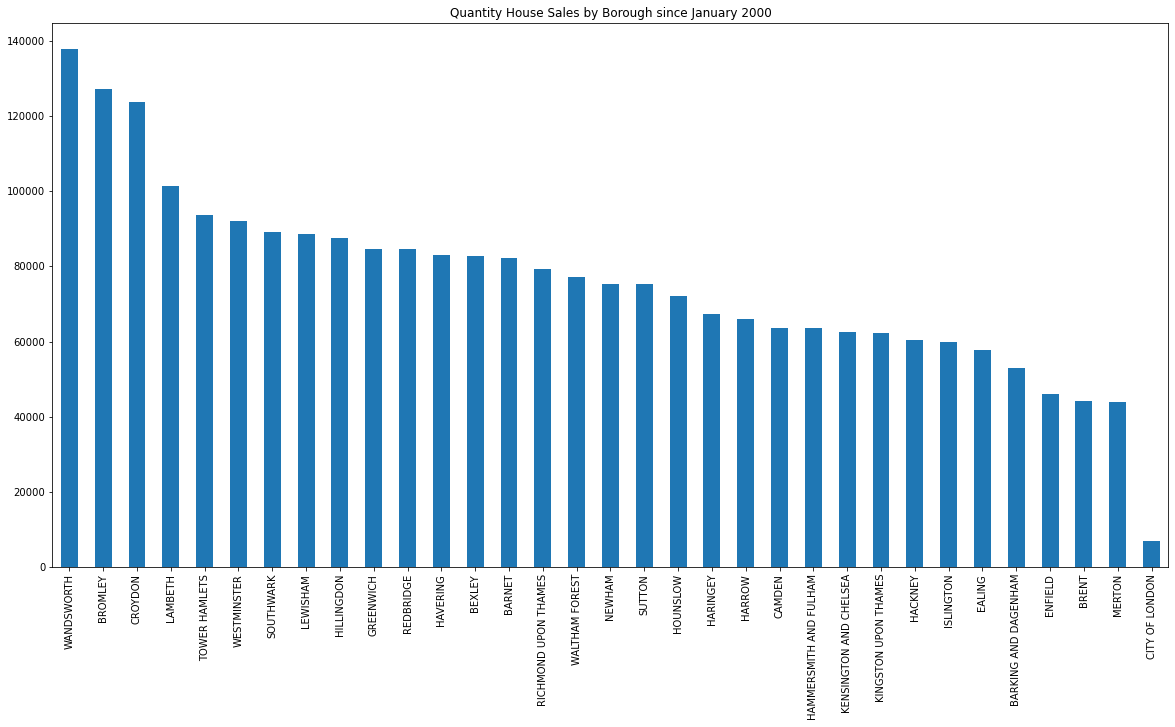

In [28]:
# I will now review the counts again, see where this dataset stands
plt.figure(figsize=(20,10))
new['district'].value_counts().plot(kind='bar', title='Quantity House Sales by Borough since January 2000')

In [29]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
5011
property_type
0
new_build
0
estate_type
0
saon
1624041
paon
39
street
1057
locality
1379534
town
0
district
0
county
0
transaction_category
0
linked_data
0


In [30]:
new.dropna(subset=['postcode'], inplace=True)

In [31]:
for col in new.columns:
    print(col)
    print(new[col].isna().sum())

unique_id
0
price_paid
0
deed_date
0
postcode
0
property_type
0
new_build
0
estate_type
0
saon
1622014
paon
39
street
974
locality
1375453
town
0
district
0
county
0
transaction_category
0
linked_data
0


As I am only interested in the first part of the post code and not going to the next level of detail using the second half, I will create a new column by extracting this information from the post code column.

In [32]:
new[['zip','Last']] = new.postcode.str.split(" ",1, expand=True,)
new.head()

unique_id  price_paid   deed_date postcode  \
0  10BACA68-F56C-47CE-906B-4D9CD4FEF39A      123000  27/01/2000   E1 0AF   
1  F6339A0D-34F8-44DD-AC6B-AE266FC884EE       80000  28/09/2001   E1 0AJ   
2  73441E21-34A6-444A-B5DA-310A673CC3F6       60000  21/06/2000   E1 0AR   
3  1C1202B4-E202-45B7-B7B3-BFA7A1A1E05B       61000  18/02/2000   E1 0AU   
4  B81AB99F-86F1-4E82-8622-1F26359BD594       73500  12/04/2001   E1 0AZ   

  property_type new_build estate_type     saon           paon          street  \
0             F         N           L      NaN            408    CABLE STREET   
1             F         N           L   FLAT 8  DONOVAN HOUSE    CABLE STREET   
2             F         N           L  FLAT 12    MOORE HOUSE    CABLE STREET   
3             F         N           L  FLAT 29  GOSLING HOUSE   SUTTON STREET   
4             F         N           L  FLAT 32    FOLEY HOUSE  TARLING STREET   

  locality    town       district          county transaction_category  \
0      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
1   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
2      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
3      NaN  LONDON  TOWER HAMLETS  GREATER LONDON                    A   
4   LONDON  LONDON  TOWER HAMLETS  GREATER LONDON                    A   

                                         linked_data zip Last  
0  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AF  
1  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AJ  
2  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AR  
3  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AU  
4  http://landregistry.data.gov.uk/data/ppi/trans...  E1  0AZ

In [33]:
new['Month'] = pd.DatetimeIndex(new['deed_date'])
new['month_year'] = pd.to_datetime(new['Month']).dt.to_period('M')

In [34]:
print(f'We have {new.zip.nunique()} different post codes in our dataset for London.')

We have 300 different post codes in our dataset for London.


In [35]:
new[new['month_year']>'2021-05']

unique_id  price_paid   deed_date postcode  \
47     C3C3F9B6-9A45-362B-E053-6B04A8C03ACC     3215000  09/04/2021   E1 0BL   
84     BEF7EBBF-1C2B-7A76-E053-6B04A8C092F7      630000  08/01/2021   E1 0ED   
205    C18F412A-B78D-81A6-E053-6B04A8C0AD18      665000  10/03/2021   E1 0NQ   
230    C3C3F9B5-9F64-362B-E053-6B04A8C03ACC      407500  10/02/2021   E1 0QA   
575    C18F412A-B94A-81A6-E053-6B04A8C0AD18     1050000  11/02/2021   E1 2AN   
...                                     ...         ...         ...      ...   
71146  C3C3F9B6-0FAA-362B-E053-6B04A8C03ACC      415000  12/03/2021   W4 5RH   
71258  C6209F5E-CFA4-295E-E053-6C04A8C0DDCC      761500  11/03/2021   W4 5SB   
71265  C6209F5F-9073-295E-E053-6C04A8C0DDCC     1607000  09/02/2021   W4 5SB   
71554  C6209F5E-D3F3-295E-E053-6C04A8C0DDCC      405000  09/04/2021   W4 5UW   
72021  C6209F5E-D095-295E-E053-6C04A8C0DDCC      682500  11/06/2021   W6 0YE   

      property_type new_build estate_type               saon            paon  \
47                O         N           F                NaN             212   
84                F         N           F                NaN              30   
205               T         N           F                NaN              50   
230               F         N           L                NaN               2   
575               T         N           F                NaN               6   
...             ...       ...         ...                ...             ...   
71146             F         N           L             FLAT 1  MORTLAKE HOUSE   
71258             F         N           L  GROUND FLOOR FLAT              39   
71265             T         N           F                NaN              43   
71554             F         N           L                NaN              24   
72021             F         N           L                NaN              27   

                   street locality    town       district          county  \
47           CABLE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
84           TARBERT WALK      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
205       BELGRAVE STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
230       OLD CHURCH ROAD      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
575         WALDEN STREET      NaN  LONDON  TOWER HAMLETS  GREATER LONDON   
...                   ...      ...     ...            ...             ...   
71146  CHISWICK HIGH ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71258  THORNEY HEDGE ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71265  THORNEY HEDGE ROAD      NaN  LONDON       HOUNSLOW  GREATER LONDON   
71554        ALFRED CLOSE      NaN  LONDON       HOUNSLOW  GREATER LONDON   
72021    RANELAGH GARDENS      NaN  LONDON       HOUNSLOW  GREATER LONDON   

      transaction_category                                        linked_data  \
47                       B  http://landregistry.data.gov.uk/data/ppi/trans...   
84                       A  http://landregistry.data.gov.uk/data/ppi/trans...   
205                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
230                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
575                      A  http://landregistry.data.gov.uk/data/ppi/trans...   
...                    ...                                                ...   
71146                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71258                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71265                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
71554                    A  http://landregistry.data.gov.uk/data/ppi/trans...   
72021                    A  http://landregistry.data.gov.uk/data/ppi/trans...   

      zip Last      Month month_year  
47     E1  0BL 2021-09-04    2021-09  
84     E1  0ED 2021-08-01    2021-08  
205    E1  0NQ 2021-10-03    2021-10  
230    E1  0QA 2021-10-02    2021-10  
575    E1  2AN 2021

In [36]:
# Ensure that we erradicate very low prices from data set
new = new[new['price_paid']>10000]

# remove outliers from the data
no_outliers = new[(np.abs(stats.zscore(new['price_paid'])) < 3)].copy()

no_outliers = no_outliers[no_outliers['month_year']<'2021-06'].copy()

count    2.474631e+06
mean     3.989441e+05
std      4.411951e+05
min      1.001100e+04
25%      1.870000e+05
50%      2.800000e+05
75%      4.500000e+05
max      6.520000e+06
Name: price_paid, dtype: float64

In [37]:
new.to_csv('final.csv')
no_outliers.to_csv('no_outliers.csv')

In [38]:
no_outliers['deed_date'] = pd.to_datetime(no_outliers['deed_date'])
s = no_outliers.groupby(['zip',pd.Grouper(key='deed_date', freq='MS')])['price_paid'].mean()

df1 = (s.reset_index(level=0)
        .groupby('zip')['price_paid']
        .apply(lambda x: x.asfreq('MS'))
        .reset_index()
        )

In [39]:
df1.isna().sum()

zip              0
deed_date        0
price_paid    8492
dtype: int64

In [40]:
df1.groupby('zip').head()

zip  deed_date     price_paid
0      BR1 2000-01-01  188510.882353
1      BR1 2000-02-01  166975.060606
2      BR1 2000-03-01  166774.318182
3      BR1 2000-04-01  184542.528090
4      BR1 2000-05-01  164167.565789
...    ...        ...            ...
71012  WD3 2000-01-01  155000.000000
71013  WD3 2000-02-01            NaN
71014  WD3 2000-03-01            NaN
71015  WD3 2000-04-01            NaN
71016  WD3 2000-05-01            NaN

[1473 rows x 3 columns]

In [42]:
print(f'We have {df1.zip.nunique()} different post codes in our dataset for London.')

We have 299 different post codes in our dataset for London.


In [43]:
df1.to_csv('df1.csv')

# EDA

London is an expensive city, everyone knows this, but is it true for all boroughs?

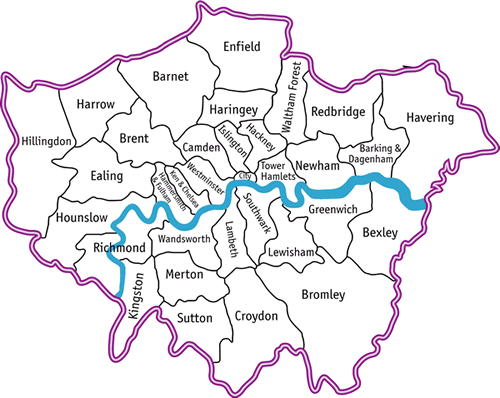

In [94]:
# set the filepath and load in a shapefile
fp = 'London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)
# load the average price data per borough
averages = pd.read_csv('boroughs.csv')
averages['average price'] = averages['average price'].str.replace(',', '')
averages['average price'] = averages['average price'].astype(int)
#merge with the geodataframe
merged = map_df.set_index('NAME').join(averages.set_index('borough'))

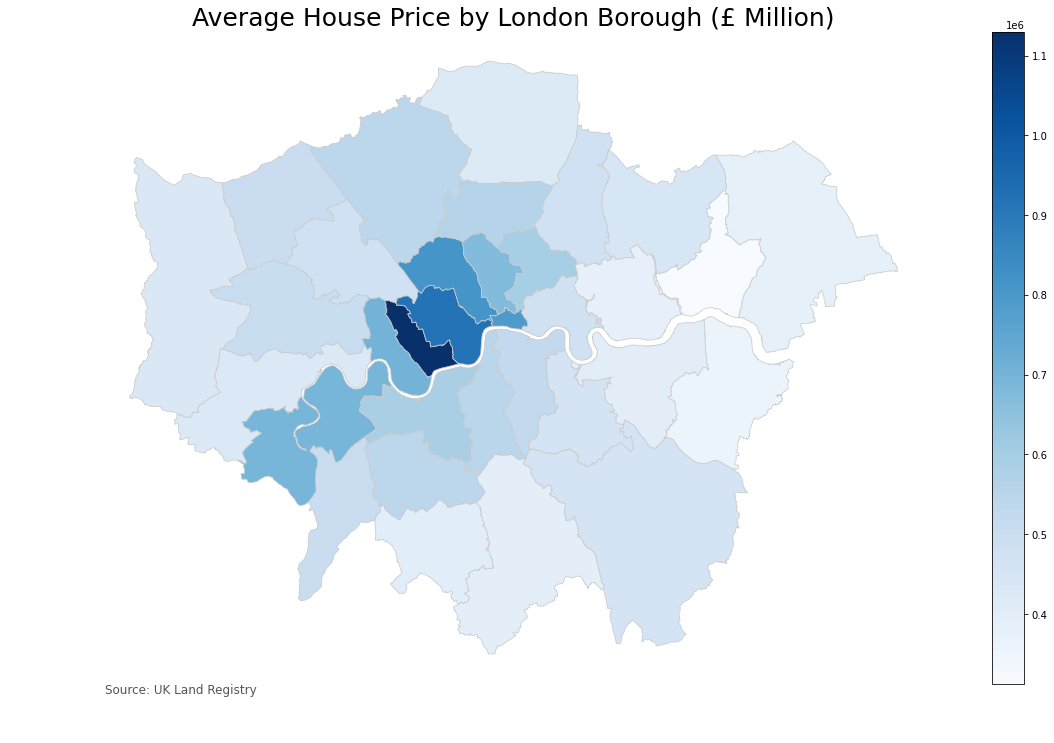

In [99]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'average price'
# set the range for the choropleth
vmin, vmax = merged['average price'].min(), merged['average price'].max()
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 12))
ax.axis('off')
ax.set_title('Average House Price by London Borough (£ Million)', fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: UK Land Registry',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax.set_ylabel('x')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8');


London is vast, with 32 Boroughs and The City of London. It can take over 2 hours to navigate from one side to the other, so it is to be expected that there is a lot of diversity in the housing stock. 
This is reflected when you look at the top 5 most expensive Boroughs vs the top 5 most affordable. As can be seen from the map above, Boroughs in Central London and West London are among the most expensive. Kensington and Chelsea has an average house price of over £1million! 

How has this changed over time?

This project is interested in forecasting prices in the future, with that in mind it is useful to look at how prices have varied through time in the past. In london, it can seen some Boroughs have increased more than others.

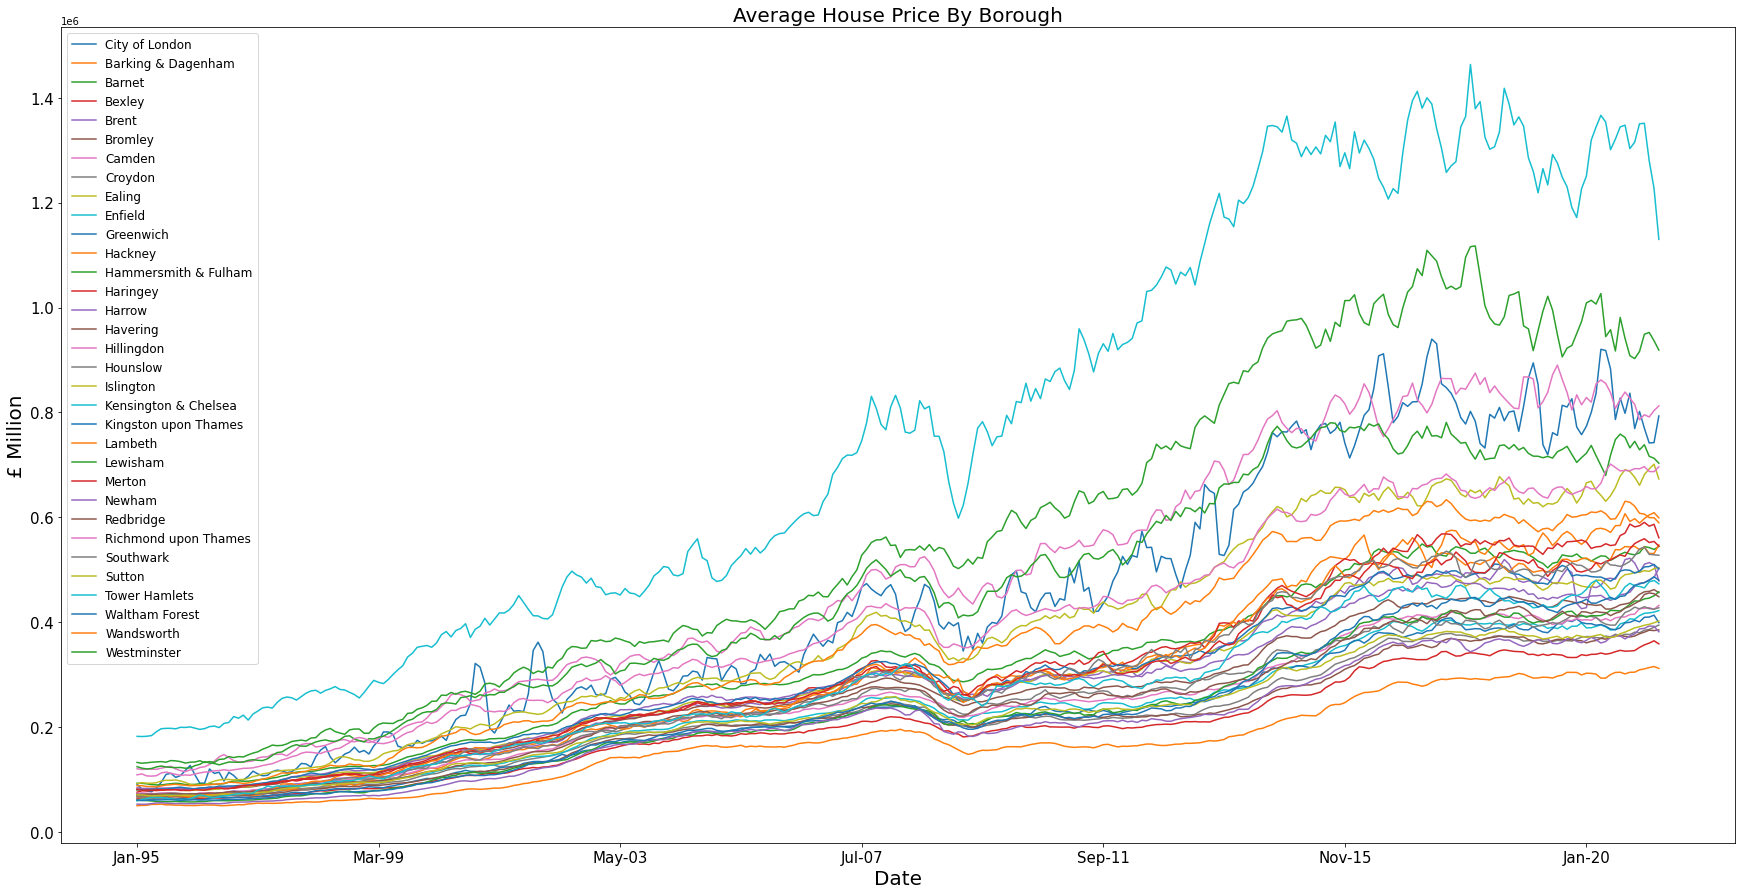

In [93]:
boroughs_time = pd.read_csv('boroughs_averages.csv')
boroughs_time.set_index('Date', inplace=True)
boroughs_time.head()
boroughs_time.plot(figsize=(30,15));
plt.title('Average House Price By Borough', fontsize=20)
plt.legend(fontsize=12)
plt.ylabel('£ Million', fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.tick_params(labelsize=15)
plt.savefig('../Images/price_history.png', bbox_inches='tight')

It's very interesting, it may look as if all prices have just gone up, but closer inspection shows that not to be the case.
Very expensive Boroughs, such as Kensington & Chelsea and Westminster are clearly more volatile with higher peaks but deeper troughs. If you have the money to buy here do so with caution. 
Other Boroughs tend to be more stable, gently increasing with time but still fall victim to the Global Recession in 2008. It is clear the impact of any price increase or decrease is felt more in central london, and this dissipates out to other Boroughs. It will be interesting to note the Boroughs here with more volatility and see if this is reflecting in the confidence intervals of any model.

# Modeling

There are various options available to forecasting the prices per post code. 

I will review, Facebook Prophe, ARIMA and SARIMA models. I will do this on one postcode to begin with to review the methodology, then check if this is scalable to use on other post codes.

## Baseline ARIMA

I will attempt a baseline model on one postcode, and compare against other models.

First I will check for stationarity.

In [4]:
df1 = pd.read_csv('../clean_data/df1.csv')

df1.drop('Unnamed: 0', axis=1, inplace=True)
print(df1.head())
br3 = df1[df1['zip']=='BR3'].copy()
br3.drop('zip', axis=1, inplace=True)
br3.columns = ['ds', 'y']
br3.set_index('ds', inplace=True)
br3 = br3.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
br3_train = br3[br3.index < '2019-12-01']
br3_test = br3[(br3.index >= '2019-12-01') & (br3.index < '2021-05-01')]
br3_val = br3[(br3.index >= '2019-01-01') & (br3.index < '2021-05-01')]



   zip   deed_date     price_paid
0  BR1  2000-01-01  188510.882353
1  BR1  2000-02-01  166975.060606
2  BR1  2000-03-01  166774.318182
3  BR1  2000-04-01  184542.528090
4  BR1  2000-05-01  164167.565789


In [5]:
result = adfuller(br3)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.583637
p-value: 0.874637


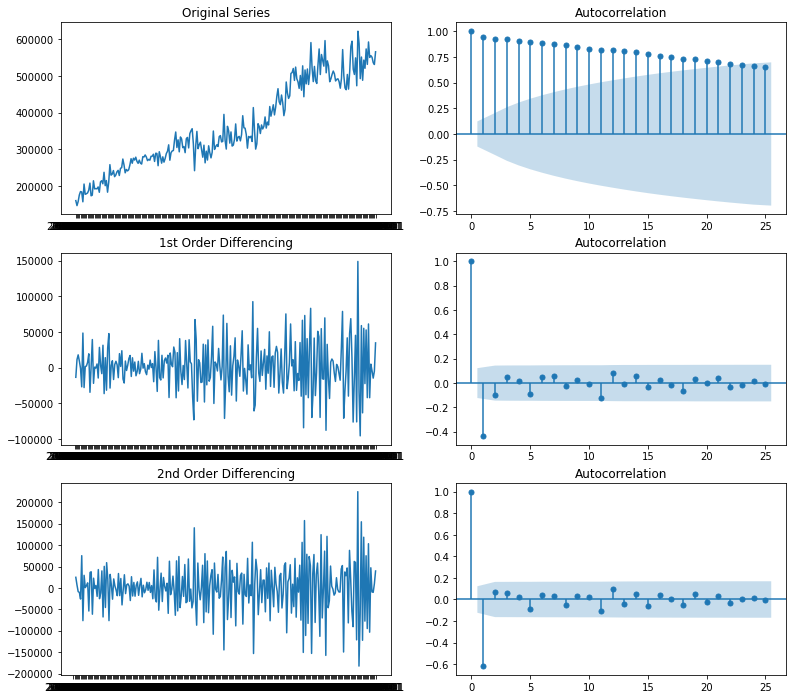

In [6]:
# Original Series

fig, axes = plt.subplots(3, 2, sharex=False)
fig.set_figwidth(13)
fig.set_figheight(12)
axes[0, 0].plot(br3); axes[0, 0].set_title('Original Series')
plot_acf(br3, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(br3.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(br3.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(br3.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(br3.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

From the plots above it looks like stationarity is achieved with first order differencing, I will check this with what pmdarima ndiffs function would recommend

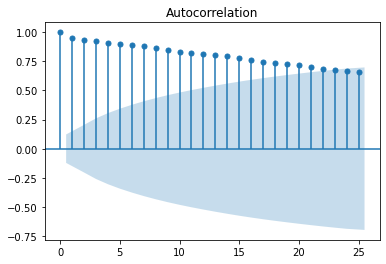

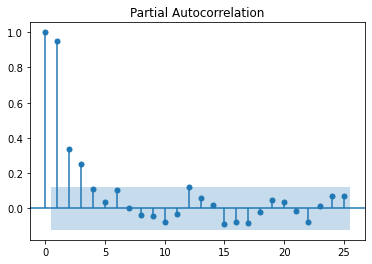

In [20]:
plot_acf(br3)
plot_pacf(br3);

In [23]:
from pmdarima.arima.utils import ndiffs
## Adf Test
print(ndiffs(br3, test='adf'))

# KPSS test
print(ndiffs(br3, test='kpss'))

# PP test:
print(ndiffs(br3, test='pp'))

1
1
0


So it looks like a differencing term of one would be reasonable. 

P value is greater than 0.05 so will require differencing to achieve stationarity

I will now try and find the P term, this can be done by looking at the PACF and checking the number of lags that are significant

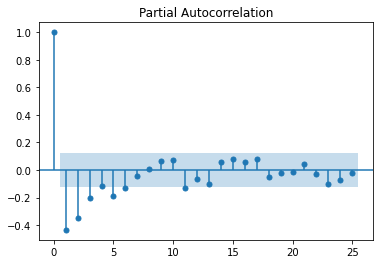

In [27]:
plot_pacf(br3.diff().dropna());

It looks like 4 or 5 could be significant. I will opt with 4.

I will now check the q term, by ploting the Autocorrelation.

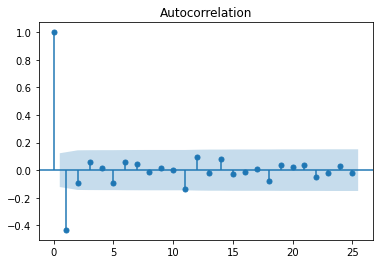

In [29]:
plot_acf(br3.diff().dropna());

it looks like only one lag is significant here, I will use 1 as my q term.

In [39]:
### Base Model

base = ARIMA(br3, order=(4,1,1), freq='MS')
base_fit = base.fit(disp=0)
print(base_fit.summary())

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  256
Model:                 ARIMA(4, 1, 1)   Log Likelihood               -2985.236
Method:                       css-mle   S.D. of innovations          28009.313
Date:                Tue, 24 Aug 2021   AIC                           5984.473
Time:                        21:28:33   BIC                           6009.289
Sample:                    02-01-2000   HQIC                          5994.454
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1476.5125    408.125      3.618      0.000     676.602    2276.423
ar.L1.D.y     -0.0167      0.119     -0.141      0.888      -0.250       0.217
ar.L2.D.y     -0.0982      0.098     -0.998      0.3

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


it appears that all of the AR terms are showing as insignificant, I will run a model with these removed. 

In [40]:
base_update = ARIMA(br3, order=(0,1,1), freq='MS')
base_update_fit = base_update.fit(disp=0)
print(base_update_fit.summary())

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  256
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -2986.007
Method:                       css-mle   S.D. of innovations          28094.643
Date:                Tue, 24 Aug 2021   AIC                           5978.013
Time:                        21:31:34   BIC                           5988.649
Sample:                    02-01-2000   HQIC                          5982.291
                         - 05-01-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1482.6089    395.335      3.750      0.000     707.766    2257.452
ma.L1.D.y     -0.7780      0.039    -20.204      0.000      -0.853      -0.703
                                    Roots           

The AIC has barely improved here, but improved nonetheless.

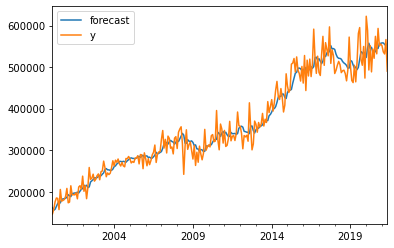

In [41]:
base_update_fit.plot_predict(dynamic=False)
plt.show()

I will now see how this performs when being splitting the data into test and training sets.

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


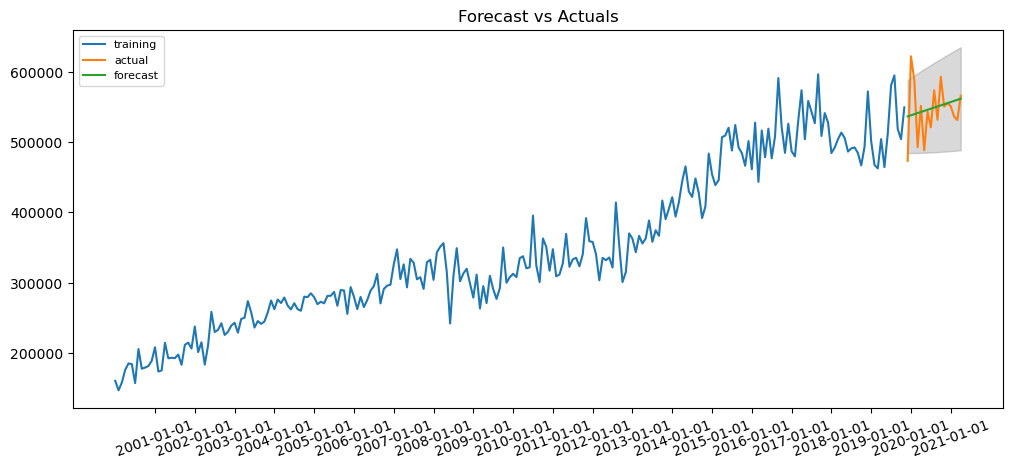

In [48]:
model = ARIMA(br3_train, order=(0, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(len(br3_test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=br3_test.index)
lower_series = pd.Series(conf[:, 0], index=br3_test.index)
upper_series = pd.Series(conf[:, 1], index=br3_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(br3_train, label='training')
plt.plot(br3_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(br3.index[12::12], rotation=20 )
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
smape(br3_test, fc_series)

5.275601218240561

Mean absolute percentage error is 5.27, not bad for first attempt. As can be seen, the model isn't necessarily capturing the variance in the forecast. 
It needs to be asked though, how important is this? If the project is aiming to forecast years into the future, it may be better to see a forecast that cuts out the noise and has an average with confidence intervals.

# SARIMA

Now its time to test for some seasonality in the model, and if there is seasonality, incorporate that into the model. 

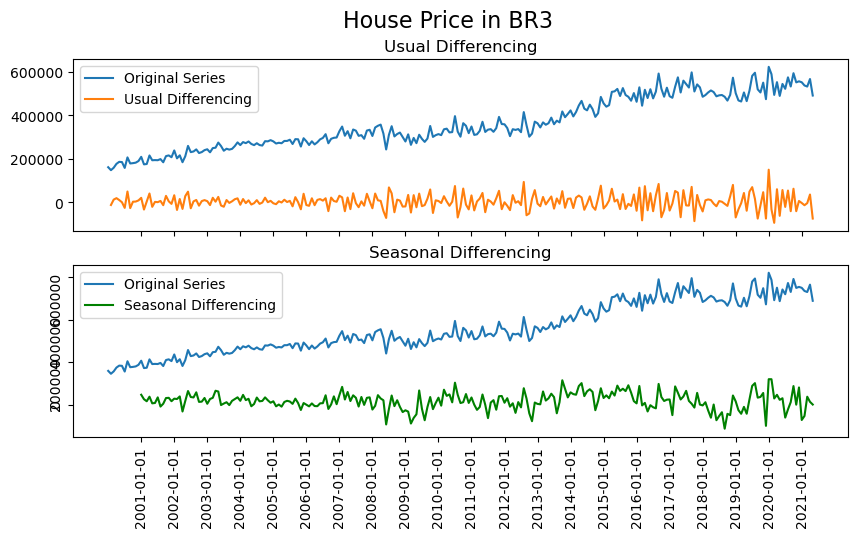

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(br3, label='Original Series')
axes[0].plot(br3.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(br3, label='Original Series')
axes[1].plot(br3.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].set_xticks(br3.index[12::12])
axes[1].tick_params(labelrotation=90)
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('House Price in BR3', fontsize=16)
plt.show()

It's difficult to see any seasonality here still visible after usual differencing so it is inconclusive, the PACF seems to indicate there is a correlation at lag 12 which would be one year, it is only marginally significant. 

In [62]:
from pmdarima.arima.utils import nsdiffs

nsdiffs(br3, 12)

0

nsdiffs suggests there is no requirement for seasonal differencing. 

I will use nested loops to search for the optimum parameters to use in the SARIMA model. 

In [ ]:
br3_test_results = pd.DataFrame(columns = ['SMAPE'])
for p in range(0,4):
    for d in range(1,3):
        for q in range(0,4):
            for P in range(0,4):
                for D in range(1,3):
                    for Q in range(0,4):
                        model = SARIMAX(br3_train, order =(p,d,q), seasonal_order = (P,D,Q,12))
                        fit_model = model.fit(maxiter = 200, disp = False)
                        yhat = fit_model.forecast(len(br3_test))
                        ind = f'order = ({p},{d},{q}), seasonal_order = ({P},{D},{Q},12)'
                        mape = smape(br3_test,yhat)
                        print(f'trying {ind}, MPE = {mape}')
                        br3_test_results.loc[ind,'MPE'] = mape

br3_test_results.min()

In [64]:
br3_test_results.min()

SMAPE        None
MPE      5.297162
dtype: object

The minimum SMAPE is 5.29 with order = (0,2,2), seasonal_order = (0,1,1,12) this is actually worse than the ARIMA model. Let's see what the forecast looks like.

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


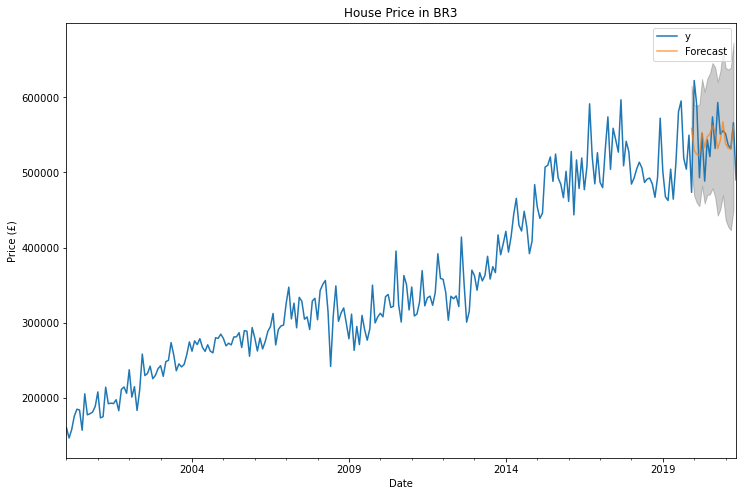

In [86]:
sarima_model = SARIMAX(br3_train, order=(0, 2, 2), seasonal_order = (0,1,1,12), freq='MS')  
sarima_fitted = sarima_model.fit(disp=-1, freq='MS')  

prediction_sarima = sarima_fitted.get_forecast(steps=len(br3_test))
prediction_sarima.summary_frame()
forecast_ci = prediction_sarima.conf_int()
br3.index = pd.to_datetime(br3.index, format = '%Y/%m/%d')

ax = br3.plot(figsize=(12,8), label='Actual', xlabel='Date', ylabel='Price (£)', title='House Price in BR3')

prediction_sarima.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(prediction_sarima.summary_frame().index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2);

plt.legend()


Ok, so SARIMA certainly captures more variance in the forecast, but the SMAPE is slightly higher than ARIMA. Also this method of finding the best parameters is painstaking, if this is to be scalable I will need to utilise another solution.

# Auto ARIMA

I will now trial Auto-ARIMA on one zip to check results

In [4]:
#We use the ‘Augmented Dickey-Fuller Test’ to check whether the data is stationary or not
adf_test=ADFTest(alpha=0.05)
adf_test.should_diff(br3)


(0.504398791426278, True)

### Assuming no seasonality

In [89]:
auto_model = auto_arima(br3_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=0,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5558.760, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5622.151, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5588.394, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5552.880, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5620.762, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5568.696, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5551.772, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=5552.585, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=5552.013, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=5587.894, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5552.951, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.874 seconds


### With Seasonality

In [90]:
model=auto_arima(br3_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5455.998, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5384.692, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5323.839, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5397.415, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5325.667, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5325.661, Time=0.40 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5354.030, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5327.808, Time=0.50 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=5382.068, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5322.388, Time=0.35 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5396.420, Time=0.28 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5324.140, Time=0.91 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=5324.133, Time=1.38 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5352.735, Time=0.37 sec
 ARIMA(1,1,1)(1,1,2

In [91]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  239
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -2655.714
Date:                              Wed, 25 Aug 2021   AIC                           5319.427
Time:                                      20:26:21   BIC                           5333.109
Sample:                                           0   HQIC                          5324.949
                                              - 239                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5227      0.095     -5.493      0.000      -0.709      -0.336
ma.L2         -0.1135      0.094     -1.211      0.226      -0.297       0.070
ma.S.L12      -0.7895      0.082     -9.677      0.000      -0.949      -0.630
sigma2      1.275e+09   2.01e-11   6.33e+19      0.000    1.28e+09    1.28e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):                21.92
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.49e+35. Standard errors may be unstable.
"""

In [92]:
prediction = pd.DataFrame(model.predict(n_periods = len(br3_test)),index=br3_test.index)
prediction.columns = ['predicted_price']
prediction

predicted_price
ds                         
2019-12-01    566647.379121
2020-01-01    531245.915576
2020-02-01    526292.950558
2020-03-01    526553.219829
2020-04-01    559309.794961
2020-05-01    538007.175842
2020-06-01    555189.584044
2020-07-01    561321.264941
2020-08-01    573416.238005
2020-09-01    565226.888164
2020-10-01    541562.887742
2020-11-01    555617.825736
2020-12-01    584003.669078
2021-01-01    551237.911279
2021-02-01    546284.946261
2021-03-01    546545.215531
2021-04-01    579301.790664

In [100]:
br3_train.index = pd.to_datetime(br3_train.index, format = '%Y/%m/%d')
br3_test.index = pd.to_datetime(br3_test.index, format = '%Y/%m/%d')
prediction.index = pd.to_datetime(prediction.index, format = '%Y/%m/%d')

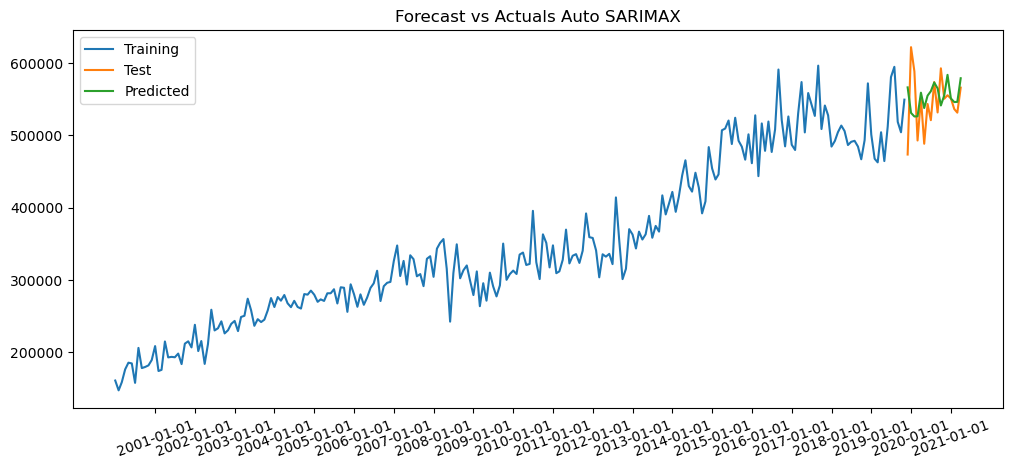

In [106]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(br3_train,label="Training")
plt.plot(br3_test['y'],label="Test")
plt.plot(prediction,label="Predicted")
plt.xticks(br3.index[12::12], rotation=20 )
plt.title('Forecast vs Actuals Auto SARIMAX')
plt.legend(loc = 'upper left')
plt.show()


In [103]:
br3_test['predicted_price'] = prediction
smape(br3_test['y'], br3_test['predicted_price'])

<ipython-input-103-5753df95daa2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br3_test['predicted_price'] = prediction


5.876876743392727

So the mean absolute percentage error is still close to the best achieved so far (5.27) and it takes a fraction of the time. It also captures variance in the forecast, the question is though should I be interested in this variance or would predicting a rolling mean be more useful?

## Auto ARIMA with Rolling Mean

In [107]:
br3_ave = br3.rolling(window=12, center=False).mean()

In [109]:
br3ave_train = br3_ave[(br3_ave.index >= '2000-12-01') & (br3_ave.index < '2019-12-01')]
br3ave_test = br3_ave[(br3_ave.index >= '2019-12-01') & (br3_ave.index < '2021-05-01')]


In [110]:
model_roll=auto_arima(br3ave_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4284.312, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4268.295, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4281.746, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4262.372, Time=0.36 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=4259.982, Time=0.74 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=4259.876, Time=2.16 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=4260.318, Time=3.77 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=4254.726, Time=8.53 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=2.76 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=4256.502, Time=11.52 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=4256.043, Time=6.13 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=4.71 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=9.41 sec
 ARIMA(0,1,0)(4,1,1)[12]             :

In [111]:
prediction, conf = model_roll.predict(n_periods = len(br3ave_test), return_conf_int=True)

In [112]:
preds = pd.DataFrame(prediction, columns = ['preds'], index=br3ave_test.index)
conf_int = pd.DataFrame(conf, columns = ['low', 'high'], index=br3ave_test.index)

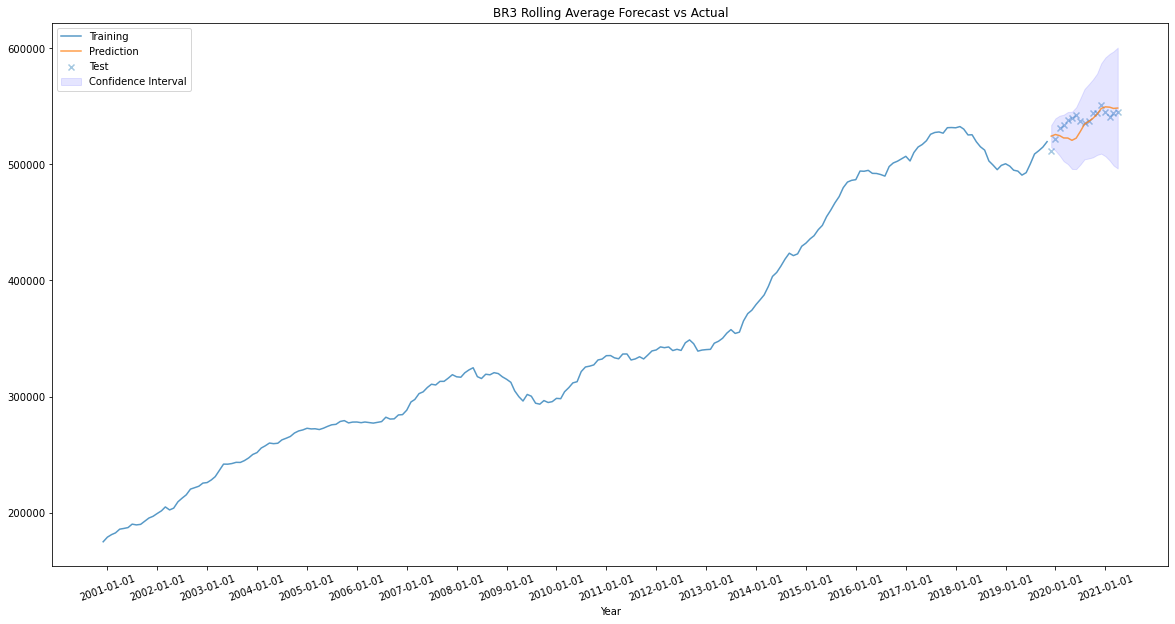

In [129]:
plt.figure(figsize=(20,10))
plt.plot(br3ave_train, alpha=0.75, label="Training")
plt.plot(preds, alpha=0.75, label='Prediction')  # Forecasts
plt.scatter(br3ave_test.index, br3ave_test,
            alpha=0.4, marker='x', label='Test')  # Test data
plt.fill_between(br3ave_test.index, conf_int['high'], conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
plt.legend(loc='upper left')
plt.xticks(br3_ave.index[12::12], rotation=20 )
plt.title("BR3 Rolling Average Forecast vs Actual")
plt.xlabel("Year");

In [115]:
smape(br3ave_test['y'], preds)

1.427168629768669

A big improvement in the Symmetric mean absolute percent error, compared to ~5% for the models that did not use rolling average. I will now update this model and retrain on the full data set including the test, to generate a forecast.

In [116]:
model_roll.update(br3ave_test)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(4, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [123]:
new_prediction, new_conf = model_roll.predict(n_periods = 60, return_conf_int=True)

In [124]:
rng = pd.date_range('2021-05-01', periods=60, freq='MS')

In [125]:
br3_ave.index = pd.to_datetime(br3_ave.index, format = '%Y/%m/%d')

In [127]:
new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng)
new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng)

Text(0.5, 1.0, 'BR3 Rolling Average Forecast')

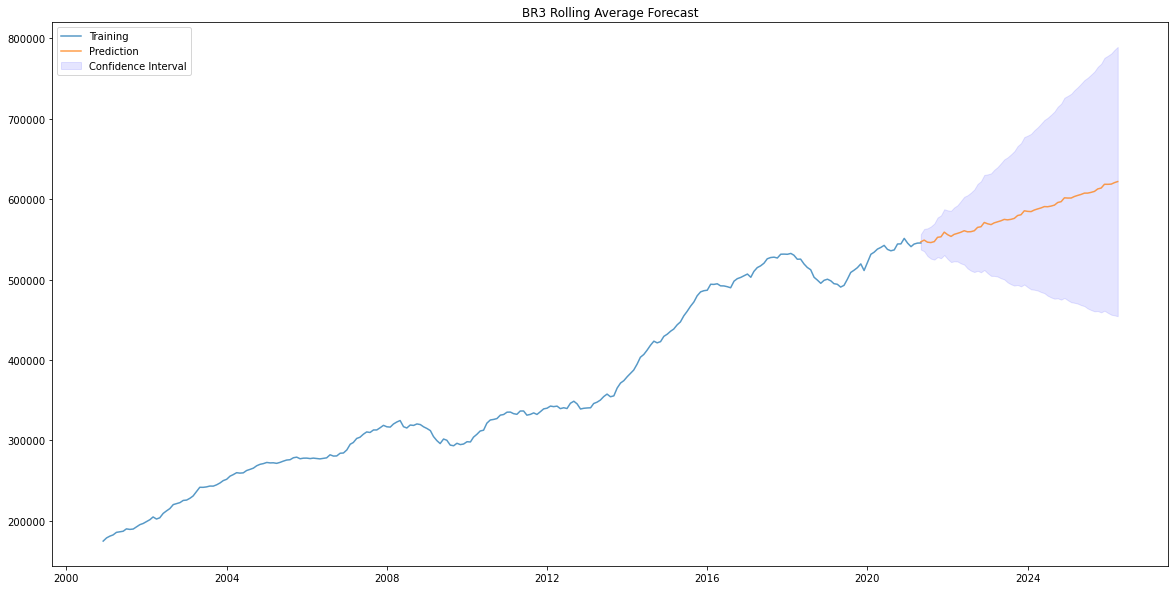

In [130]:
plt.figure(figsize=(20,10))
plt.plot(br3_ave, alpha=0.75, label="Training")
plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
plt.legend(loc='upper left')
plt.title("BR3 Rolling Average Forecast")

This approach is reasonably fast and compares well against other more labour intensive methods. For a project that requires the evaluation of so many zip codes, it seems sensible to use pmdarima and utilise it for the rest of the zip codes.

# Auto ARIMA Full Dataset

In [163]:
# create list of zip codes to model
list_of_zips = list(df1['zip'].unique())

#creat dataframes to store results
summary_test = pd.DataFrame({'Zip': [], 'SMAPE':[]})
summary_forecast = pd.DataFrame({'Zip': [], '5_year_Low_price': [], '5_year_mid_price': [], '5_year_high_price': [], 'low_ror_%': [], 'mid_ror_%': [], 'high_ror_%': []})

#create trial list of zip codes to test for loop functionality
trials = ['BR1', 'BR2']

Zip     SMAPE
0  BR1  8.031762
1  BR2  3.630422

## For Loop for Zip Code Modeling

This will be a key piece of code that will find the best parameters for all zip codes and save the model accordingly. 

In [183]:
for x,i in enumerate(list_of_zips):
    # 
    df = df1[df1['zip']==i].copy()
    # rule out zip codes that dont have complete set of dates
    if len(df) < 257:
        continue
    df.drop('zip', axis=1, inplace=True)
    df.columns = ['ds', 'y']
    df.set_index('ds', inplace=True)
    df.index = pd.to_datetime(df.index, format = '%Y/%m/%d')
    # forward fill NaNs
    df = df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
    print(i)
    print(df.head())
    df_ave = df.rolling(window=12, center=False).mean()
    train = df_ave[(df_ave.index >= '2000-12-01') & (df_ave.index < '2019-12-01')]
    test = df_ave[(df_ave.index >= '2019-12-01') & (df_ave.index < '2021-05-01')]
    # generate auto arima model
    model=auto_arima(train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=12, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
    # get predictions and confidence intervals
    prediction, conf = model.predict(n_periods = len(test), return_conf_int=True)
    preds = pd.DataFrame(prediction, columns = ['preds'], index=test.index)
    conf_int = pd.DataFrame(conf, columns = ['low', 'high'], index=test.index)
    # plot actual test data vs forecast test data
    plt.figure(figsize=(20,10))
    plt.plot(train, alpha=0.75, label="Training")
    plt.plot(preds, alpha=0.75, label='Prediction')  # Forecasts
    plt.scatter(test.index, test,
            alpha=0.4, marker='x', label='Test')  # Test data
    plt.fill_between(test.index, conf_int['high'], conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
    plt.legend(loc='upper left')
    plt.xticks(df_ave.index[12::12], rotation=20 )
    plt.title("{} Prediction vs Test".format(i), fontsize=20)
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Price (£)", fontsize=20)
    #save the figure
    plt.savefig('../Images/{}_test.png'.format(i), bbox_inches = 'tight')
    #close to ensure it doesn't output in the cell and slow down the notebook
    plt.close()
    #find the SMAPE
    smape_auto = smape(test['y'], preds)
    summary_test.loc[x] = [i, smape_auto]
    print('Symmetric Mean Absolute Percentage Error: ', smape_auto)
    #update the best model for each zip with the test data and train on entire dataset then generate new forecast
    model.update(test)
    new_prediction, new_conf = model.predict(n_periods = 60, return_conf_int=True)
    # generate dataframe of periods to be predicted
    rng = pd.date_range('2021-06-01', periods=60, freq='MS')
    df_ave.index = pd.to_datetime(df_ave.index, format = '%Y/%m/%d')
    new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng)
    new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng)
    plt.figure(figsize=(20,10))
    plt.plot(df_ave, alpha=0.75, label="Training")
    plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
        plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
    plt.legend(loc='upper left')
    plt.xlabel("Year", fontsize=20)
    plt.ylabel("Price (£)", fontsize=20)
    plt.title("{} Forecast".format(i), fontsize=20)
    plt.savefig('../Images/{}_forecast.png'.format(i), bbox_inches = 'tight')
    plt.close()
    # generate low mid and high rate of returns
    lowror = round((((new_conf_int['low'].iloc[-1] - new_conf_int['low'].iloc[0])/new_conf_int['low'].iloc[0])*100), 2)
    midror = round((((new_preds['preds'].iloc[-1] - new_preds['preds'].iloc[0])/new_preds['preds'].iloc[0])*100),2)
    highror = round((((new_conf_int['high'].iloc[-1] - new_conf_int['high'].iloc[0])/new_conf_int['high'].iloc[0])*100), 2)
    # update forecast dataframe with results
    summary_forecast.loc[x] = [i, round(new_conf_int['low'].iloc[-1],0), round(new_preds['preds'].iloc[-1],0), round(new_conf_int['high'].iloc[-1],0), lowror, midror, highror]
    #save model
    with open('../models/{}.pkl'.format(i), 'wb') as pkl:
        pickle.dump(model, pkl)


BR1
                        y
ds                       
2000-01-01  188510.882353
2000-02-01  166975.060606
2000-03-01  166774.318182
2000-04-01  184542.528090
2000-05-01  164167.565789
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4457.528, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4437.736, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4426.764, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4459.100, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4414.237, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=4437.993, Time=0.14 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=4416.037, Time=0.71 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=4416.063, Time=1.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4416.359, Time=0.91 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4428.415, Time=0.51 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=1.59 sec
 ARIMA(0,1,0)(1,1,1)[12]             : 

C:\Users\Andrew\anaconda3\envs\new-env\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(0,1,1)(5,1,1)[12]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(0,1,1)(5,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(5,1,1)[12]             : AIC=inf, Time=18.09 sec
 ARIMA(0,1,0)(5,1,1)[12] intercept   : AIC=inf, Time=11.51 sec

Best model:  ARIMA(0,1,0)(5,1,1)[12]          
Total fit time: 95.184 seconds
Symmetric Mean Absolute Percentage Error:  2.876188133729136
EC2Y
                        y
ds                       
2000-01-01  293730.769231
2000-02-01  218555.555556
2000-03-01  249375.000000
2000-04-01  276928.571429
2000-05-01  202277.272727
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4992.234, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4922.688, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=4900.827, Time=0.23 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=4990.967, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=4902.288, Time=0.59 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=4902.294, Time=0.98 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AI

In [10]:
summary_forecast['address'] = summary_forecast['Zip'] + ', London, UK'

In [8]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='myGeocoder')
location = locator.geocode('HA1, London, UK')
print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))

Latitude = 51.56831203607012, Longitude = -0.3310477599316022


In [14]:
from geopy.extra.rate_limiter import RateLimiter
# # 1 - conveneint function to delay between geocoding calls
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
# # 2- - create location column
summary_forecast['location'] = summary_forecast['address'].apply(geocode)
# # 3 - create longitude, laatitude and altitude from location column (returns tuple)
summary_forecast['point'] = summary_forecast['location'].apply(lambda loc: tuple(loc.point)\
                                                              if loc else None)
# # 4 - split point column into latitude, longitude and altitude columns
summary_forecast[['latitude', 'longitude', 'altitude']] = pd.DataFrame(summary_forecast['point'].tolist(), index=summary_forecast.index)

In [287]:
summary_test.to_csv('../clean_data/test_results.csv')
summary_forecast.to_csv('../clean_data/forecast_results.csv')

In [105]:
merge_df = summary_forecast.merge(summary_test[['Zip', 'SMAPE']], on='Zip')
merge_df.head(25)

Unnamed: 0   Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  \
0            0   BR1    549279.0    756319.0     963360.0    -7.95    23.71   
1            1   BR2    405606.0    648149.0     890693.0   -22.38    20.75   
2            2   BR3    454493.0    621889.0     789285.0   -15.42    13.71   
3            3   BR4    457046.0    698053.0     939059.0   -18.72    19.04   
4            4   BR5    473077.0    621738.0     770399.0     3.32    33.14   
5            5   BR6    504773.0    706928.0     909083.0    -8.37    25.43   
6            6   BR7    471724.0    768491.0    1065257.0   -27.66    13.72   
7           10   CR0    364496.0    516969.0     669441.0   -10.85    24.46   
8           11   CR2    453648.0    608585.0     763522.0    -4.58    25.54   
9           13   CR4    145564.0    361796.0     578029.0   -51.07    15.13   
10          14   CR5    441782.0    632496.0     823211.0   -15.52    18.24   
11          16   CR7    376050.0    478941.0     581832.0    -0.33    24.59   
12          17   CR8    352725.0    615094.0     877463.0   -41.62    -1.37   
13          19   DA1    233418.0    335024.0     436630.0   -19.54    11.94   
14          20  DA14    425002.0    569674.0     714346.0    -0.52    29.98   
15          21  DA15    414948.0    570159.0     725370.0    -6.09    26.55   
16          22  DA16    373734.0    503372.0     633010.0    -6.88    23.57   
17          23  DA17    285096.0    378661.0     472226.0    -9.92    16.86   
18          24  DA18    241636.0    357397.0     473158.0   -15.14    20.75   
19          25   DA5    415209.0    565694.0     716179.0   -13.15    15.70   
20          26   DA6    476399.0    629126.0     781853.0     1.87    30.81   
21          27   DA7    392161.0    495893.0     599625.0    -3.55    20.29   
22          28   DA8    274693.0    400958.0     527223.0   -15.56    20.47   
23          29    E1    258143.0    490705.0     723267.0   -52.88   -13.40   
24          30   E10    441156.0    588475.0     735795.0    -5.14    23.07   

    high_ror           address  \
0      53.91   BR1, London, UK   
1      61.66   BR2, London, UK   
2      41.84   BR3, London, UK   
3      53.81   BR4, London, UK   
4      61.82   BR5, London, UK   
5      57.76   BR6, London, UK   
6      52.31   BR7, London, UK   
7      58.67   CR0, London, UK   
8      54.52   CR2, London, UK   
9      74.65   CR4, London, UK   
10     50.52   CR5, London, UK   
11     48.60   CR7, London, UK   
12     36.45   CR8, London, UK   
13     41.53   DA1, London, UK   
14     59.00  DA14, London, UK   
15     57.96  DA15, London, UK   
16     53.12  DA16, London, UK   
17     42.42  DA17, London, UK   
18     54.03  DA18, London, UK   
19     43.30   DA5, London, UK   
20     58.19   DA6, London, UK   
21     43.49   DA7, London, UK   
22     54.91   DA8, London, UK   
23     23.53    E1, London, UK   
24     49.78   E10, London, UK   

                                             location  \
0   (BR1, High Street, Plaistow, London Borough of...   
1   (London Borough of Bromley, London, Greater Lo...   
2   (London Borough of Bromley, London, Greater Lo...   
3   (BR4 276, The Avenue, West Wickham, London Bor...   
4   (BR5 495D, Saxville Road, London Borough of Br...   
5   (BR6 328, Park Avenue, Goddington, London Boro...   
6   (BR7 245D, Leesons Hill, London Borough of Bro...   
7   (CR0 454D, Lime Tree Grove, Shirley, London Bo...   
8   (CR2 296D, Old Farleigh Road, Selsdon, London ...   
9   (London Borough of Merton, London, Wimbledon, ...   
10  (London Borough of Croydon, London, Croydon, G...   
11  (CR7 29, Beulah Road, London Borough of Croydo...   
12  (CR8 239, Smitham Bottom Lane, London Borough ...   
13                                               None   
14  (DA14 103D, Maidstone Road, North Cray, London...   
15  (Old Farm Road (DA15), Old Farm Avenue, Halfwa...   
16  (DA16 205, Tyrrell Avenue, Blackfen, London Bo...   
17                                    

In [107]:
# create df showing top n number post codes for a metric of your choosing, if you want bottom 5, set top=False
def get_df(df, number=5, top=True, metric='mid_ror'):
        if top:
            return df.sort_values(by=metric, ascending=False)[['Zip', '5_year_Low', '5_year_mid', '5_year_high', 'low_ror', 'mid_ror', 'high_ror', 'address', 'location', 'latitude', 'longitude', 'SMAPE']].head(number)
        else:
            return df.sort_values(by=metric, ascending=True)[['Zip', '5_year_Low', '5_year_mid', '5_year_high', 'low_ror', 'mid_ror', 'high_ror', 'address', 'location', 'latitude', 'longitude', 'SMAPE']].head(number)

# Summary of Auto ARIMA Results

That was a lot of models saved and produced, lets have a look at what they tell us about the London property market. Which postcodes are best?

In [108]:
get_df(merge_df)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
28   E14    727045.0    970307.0    1213569.0    17.51    54.29     89.89   
50   HA2    490236.0    705269.0     920303.0     0.46    41.96     82.02   
38    E6    403047.0    587364.0     771682.0    -0.92    41.73     82.84   
81   N15    727345.0    858583.0     989821.0    17.91    36.92     55.32   
153  SM5    498692.0    648747.0     798801.0     5.24    34.55     62.86   

             address                                           location  \
28   E14, London, UK  (London Borough of Tower Hamlets, London, Grea...   
50   HA2, London, UK  (London Borough of Harrow, London, Harrow, Gre...   
38    E6, London, UK  (E6, Quartermile Lane, Hackney Wick, London Bo...   
81   N15, London, UK  (London Borough of Haringey, London, Wood Gree...   
153  SM5, London, UK  (London Borough of Sutton, London, Carshalton,...   

      latitude  longitude      SMAPE  
28   51.496089  -0.016983  15.882761  
50   51.566642  -0.363995   8.039662  
38   51.554626  -0.019436  15.477474  
81   51.589914  -0.099013   5.024072  
153  51.382111  -0.176929  10.959178

The best zip codes are E14, HA2, E6, N15 and SM5 where the mid case rate of return ranges between 34% and 55%.

## Low Risk

Perhaps, when investing, the client wants to select the 5 postcodes which represent the lowest downside, therefore the lowest risk. Where would the modelling recommend?

In [224]:
# sort results by descending order on low
top_5_low = list(summary_forecast.sort_values(by='low_ror', ascending=False).head()['Zip'].unique())

In [227]:
top_5_low

['N15', 'E14', 'RM9', 'TW5', 'E4']

For a start, I will review the SMAPE for each of these models, were did they have high error?

In [233]:
boolean_series = summary_auto.Zip.isin(['N15', 'E14', 'RM9', 'TW5', 'E4'])
summary_auto[boolean_series]

Zip      SMAPE
34   E14  15.882761
43    E4   1.901434
114  N15   5.024072
157  RM9   5.140949
235  TW5  22.279369

Quite a high error in the TW5 and E14 postcodes, but the test period overlaps with the pandemic which had a big impact on property prices, I am not concerned with matching this per se, more concerned with long term trends.

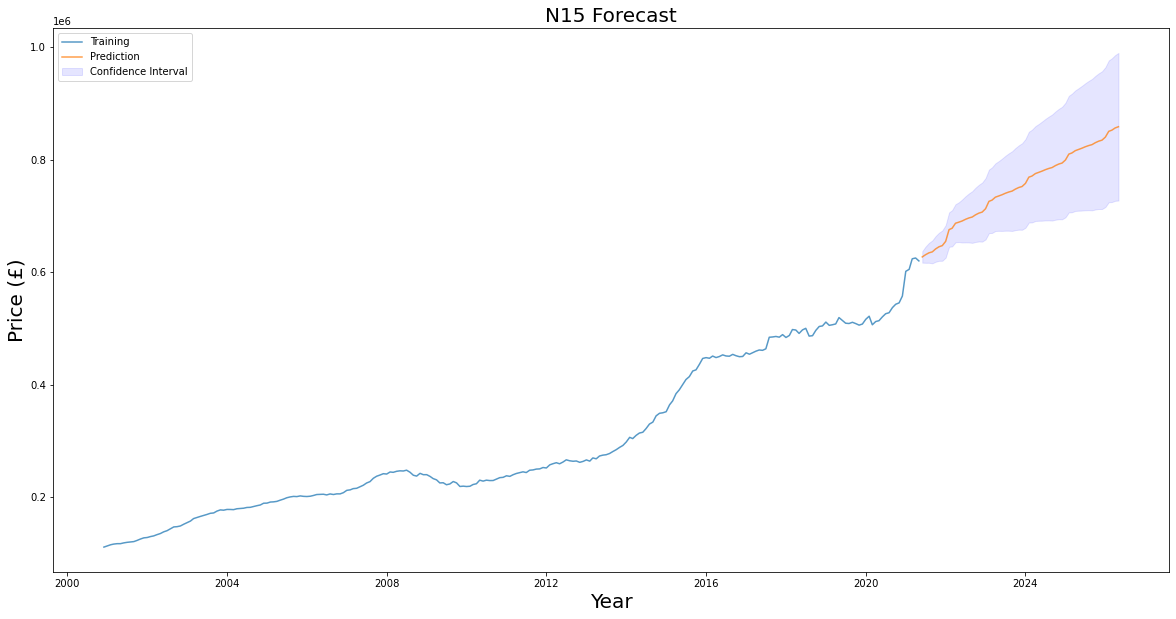

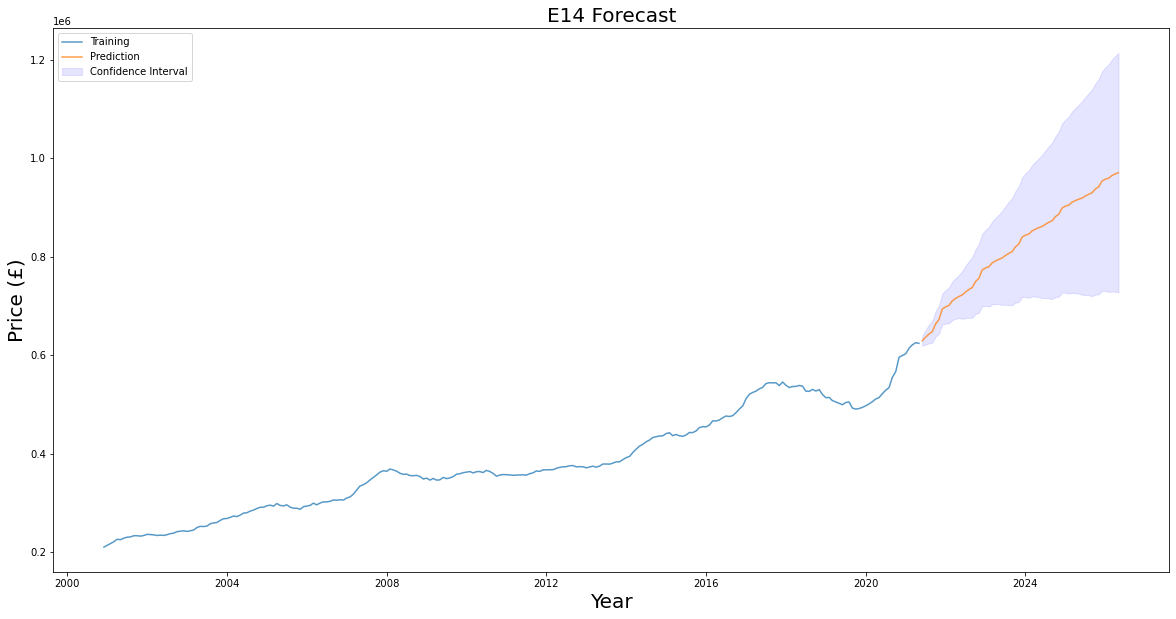

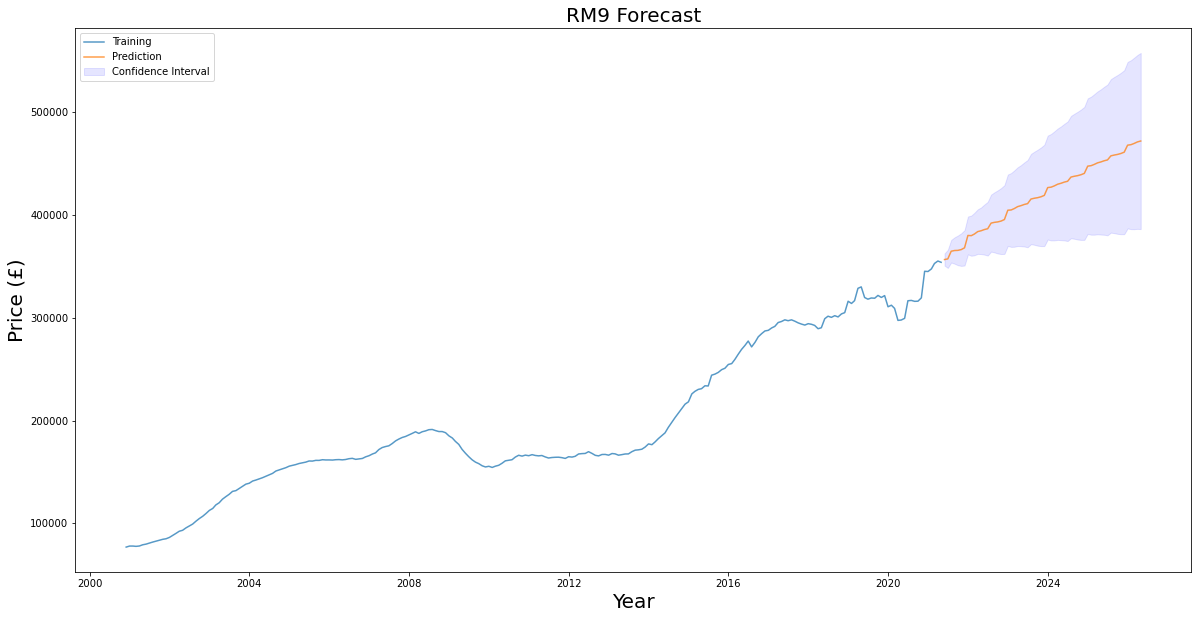

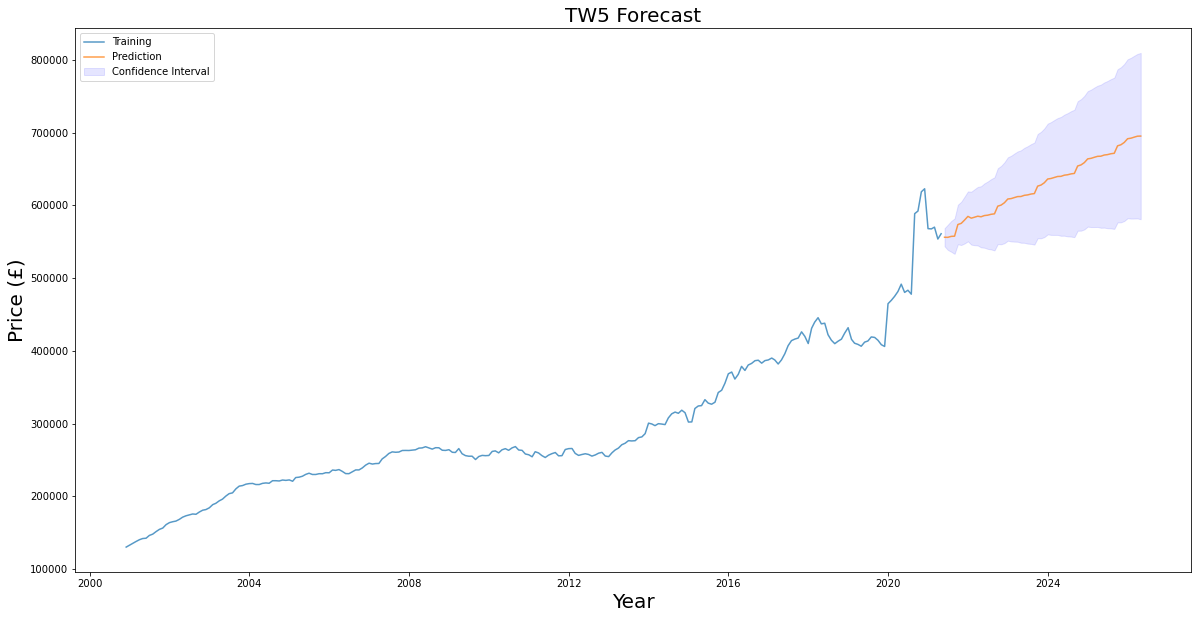

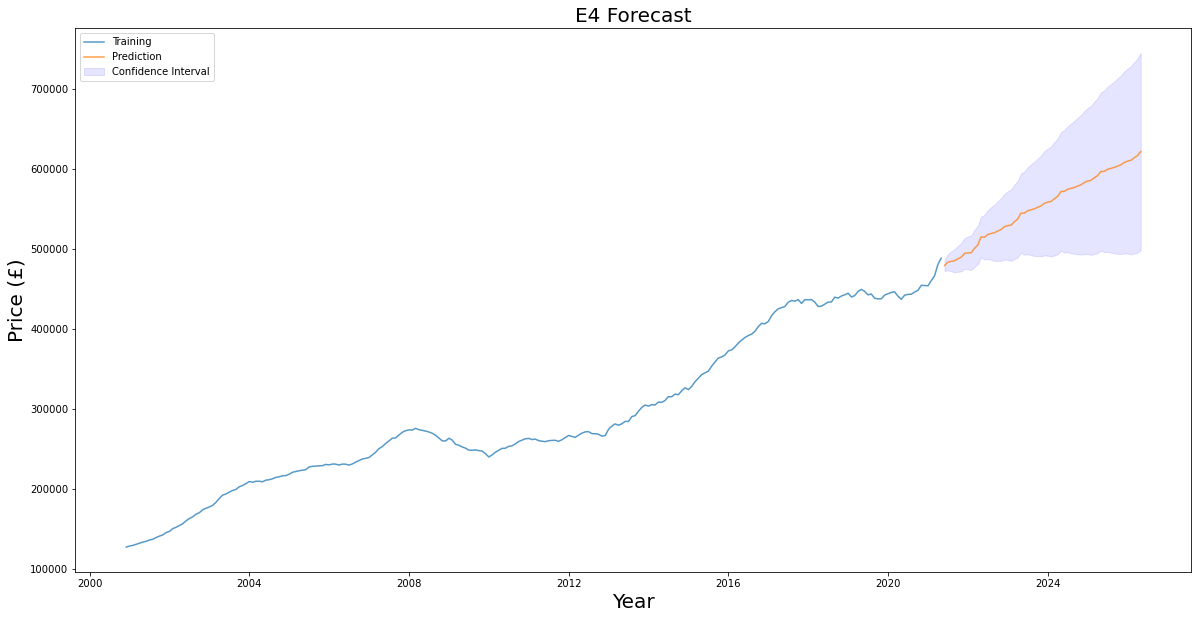

#### What will it cost to buy in these areas?

In [328]:
def get_averages(df1, any_list):
    for i in any_list:
        plt.figure(figsize=(15,8))
        df1[df1['zip']==i].set_index('deed_date')['price_paid'].tail(12).plot()
        plt.title('12 Month Average House Price in {}'.format(i), fontsize = 20)
        plt.annotate('Average Price: £{}'.format(round(df1[df1['zip']==i].set_index('deed_date')['price_paid'].tail(12).mean(),0)), xy=(0.01, 0.95), xycoords='axes fraction', fontsize=16)
        plt.ylabel('House Price (£)', fontsize=14)
        plt.xlabel('Date', fontsize=14)
    


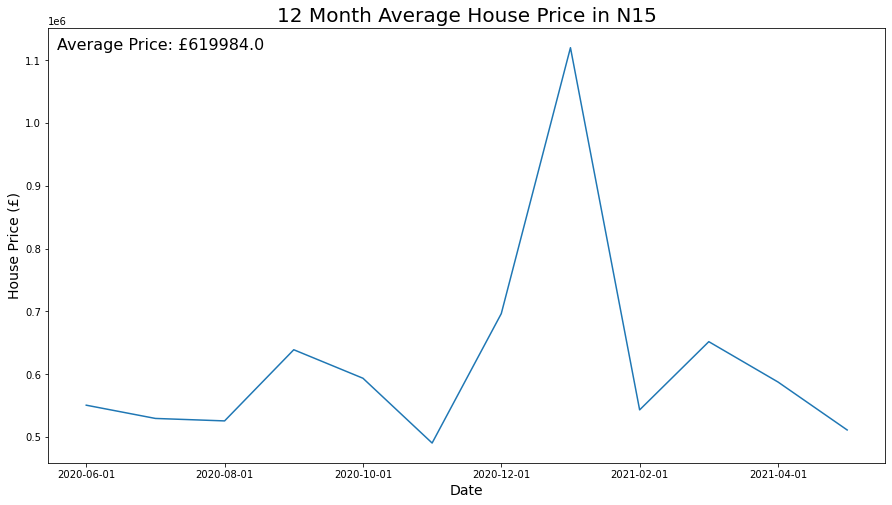

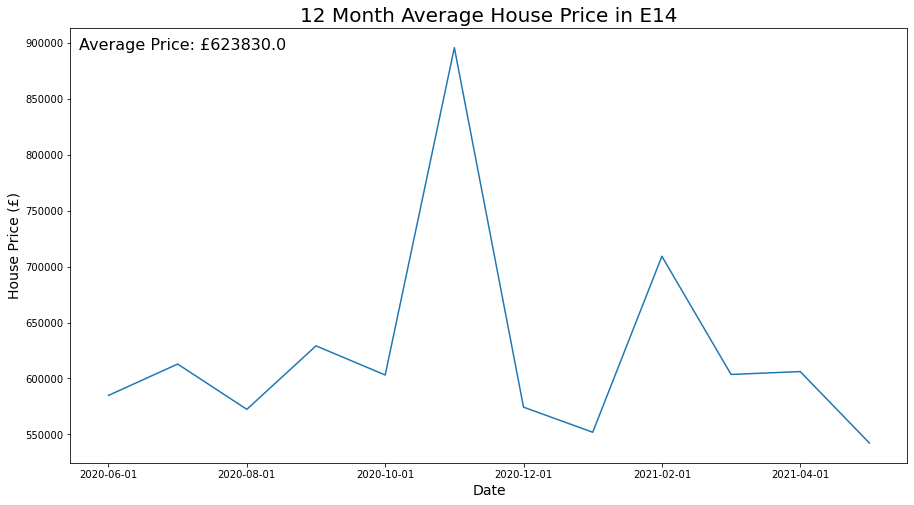

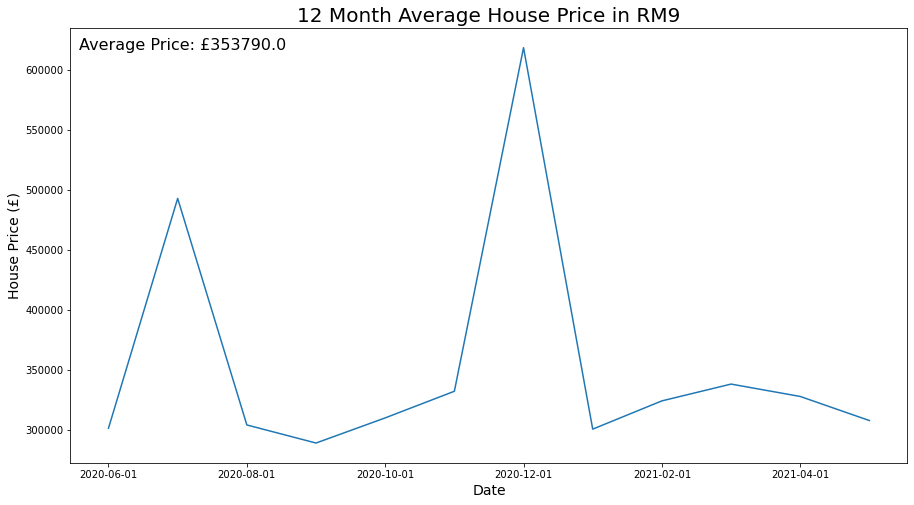

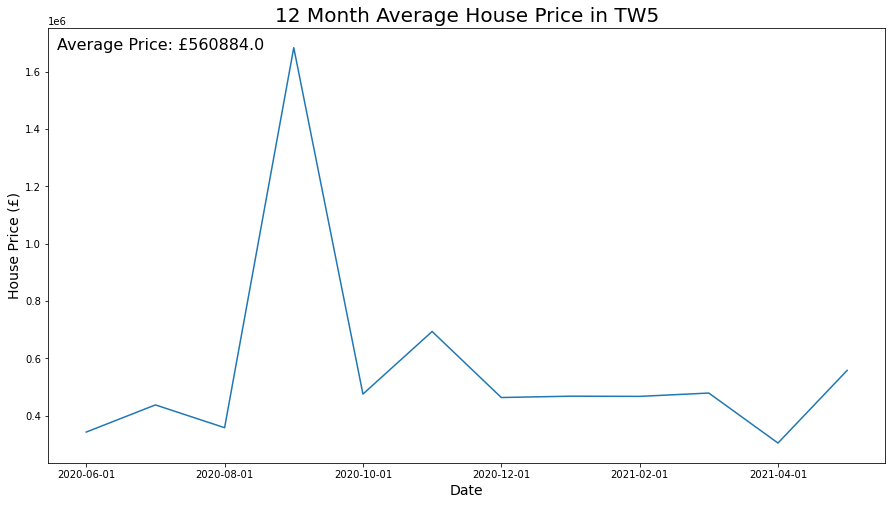

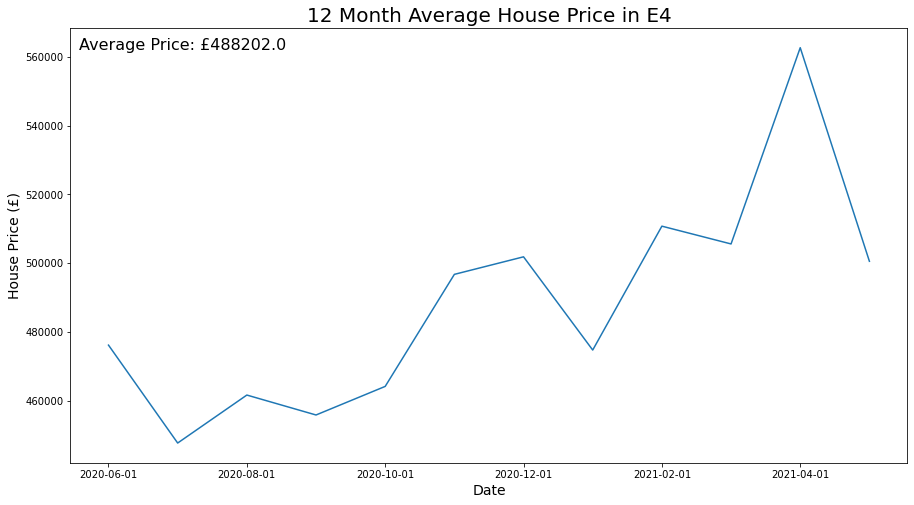

In [329]:
get_averages(df1, top_5_low)

It seems the top 5 low risk investments cover a range of budgets, which for london are reasonable: £350,000 - £625,000

### Neutral Risk

Perhaps the investor is not too concerned with losses and wants to focus on the mid case rate of return. 

<AxesSubplot:title={'center':'Mid Case Rate of Return Top 5 Postcodes'}, xlabel='Zip', ylabel='Rate of Return (%)'>

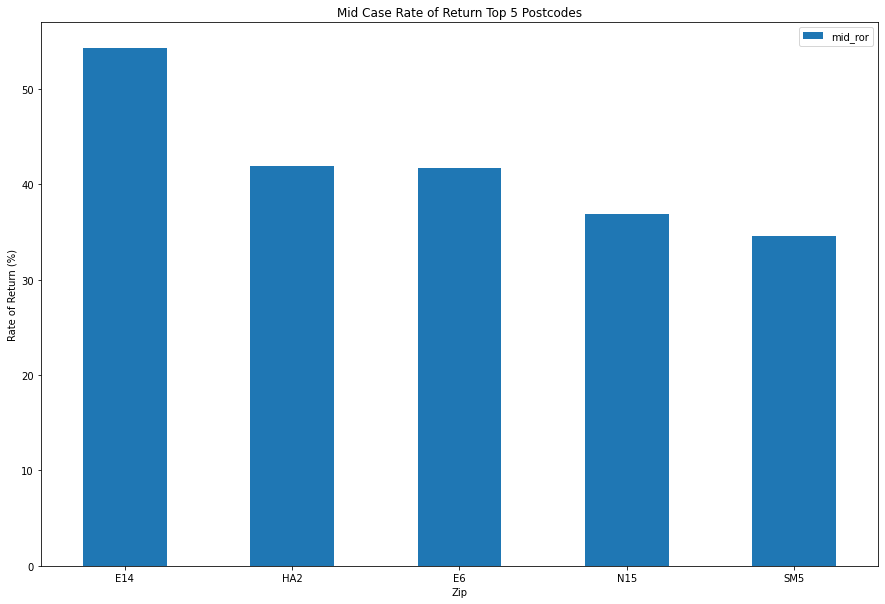

In [119]:
# sort results by descending order on low
top_5_mid = list(summary_forecast.sort_values(by='mid_ror', ascending=False).head()['Zip'].unique())
summary_forecast.sort_values(by='mid_ror', ascending=False).head().plot.bar(x='Zip', y='mid_ror', rot=0, title='Mid Case Rate of Return Top 5 Postcodes', ylabel='Rate of Return (%)', figsize=(15,10))


In [332]:
def get_forecasts(any_list):
    '''returns average house price for postcodes in list'''
    for i in any_list:
        df = df1[df1['zip']==i].copy()
        df.drop('zip', axis=1, inplace=True)
    #print(df.head())
        df.columns = ['ds', 'y']
        df.set_index('ds', inplace=True)
        df.index = pd.to_datetime(df.index, format = '%Y/%m/%d')
        df = df.interpolate(method = 'time', limit_direction = 'forward', limit_area = 'inside').fillna(0)
        df_ave = df.rolling(window=12, center=False).mean()
        with open('{}.pkl'.format(i), 'rb') as pkl:
            new_prediction, new_conf = pickle.load(pkl).predict(n_periods = 60, return_conf_int=True)
        rng = pd.date_range('2021-06-01', periods=60, freq='MS')
        df_ave.index = pd.to_datetime(df_ave.index, format = '%Y/%m/%d')
        new_preds = pd.DataFrame(new_prediction, columns = ['preds'], index=rng)
        new_conf_int = pd.DataFrame(new_conf, columns = ['low', 'high'], index=rng)
        plt.figure(figsize=(20,10))
        plt.plot(df_ave, alpha=0.75, label="Training")
        plt.plot(new_preds, alpha=0.75, label='Prediction')  # Forecasts
        plt.fill_between(new_preds.index, new_conf_int['high'], new_conf_int['low'], alpha=0.1, color='b', label='Confidence Interval')
        plt.legend(loc='upper left')
        plt.xlabel("Year", fontsize=20)
        plt.ylabel("Price (£)", fontsize=20)
        plt.title("{} Forecast".format(i), fontsize=20)
        plt.show()



In [80]:
def get_map(df):
    df = df.dropna()
    '''
    returns map of all rows of a dataframe that contain 'latitude' and 'longitude' columns
    price and address of all properties are available by clicking on the marker
    
    Parameters:
    df: df which contains 'latitude' and 'longitude' columns
    
    '''
    #Create base map zoomed in to seattle
    map4=folium.Map(location=[51.56831203607012,-0.3310477599316022],  tiles=None, zoom_start=7)
    folium.TileLayer('cartodbpositron', name='London House Price Forecast').add_to(map4)
    
    

    #Make Marker Cluster Group layer
    mcg = folium.plugins.MarkerCluster(control=False)
    map4.add_child(mcg)

    #Create layer of markers
    #Set marker popups to display name and address of service
    for row in df.iterrows():
        row_values=row[1]
        html = 'Average Current House Price in '+ row_values['address']+' is: '+'<br>'+'£'+ str(round(row_values['5_year_mid']/(1+(row_values['mid_ror']/100)),0))+ '<br>' +'Average House Price 5 years from now: '\
        +'<br>'+'£'+ str(row_values['5_year_mid'])+'<br>'+'Rate of Return: '+'<br>'+ str(row_values['mid_ror'])+'%'
        iframe = folium.IFrame(html, height=150)
        location=[row_values['latitude'], row_values['longitude']]
        popup = folium.Popup(iframe,
                     min_width=500,
                     max_width=500,
                            height=150)
        marker=folium.Marker(location=location, popup=popup, min_width=2000)
        marker.add_to(mcg)

    #Add layer control
    folium.LayerControl().add_to(map4)

    return map4

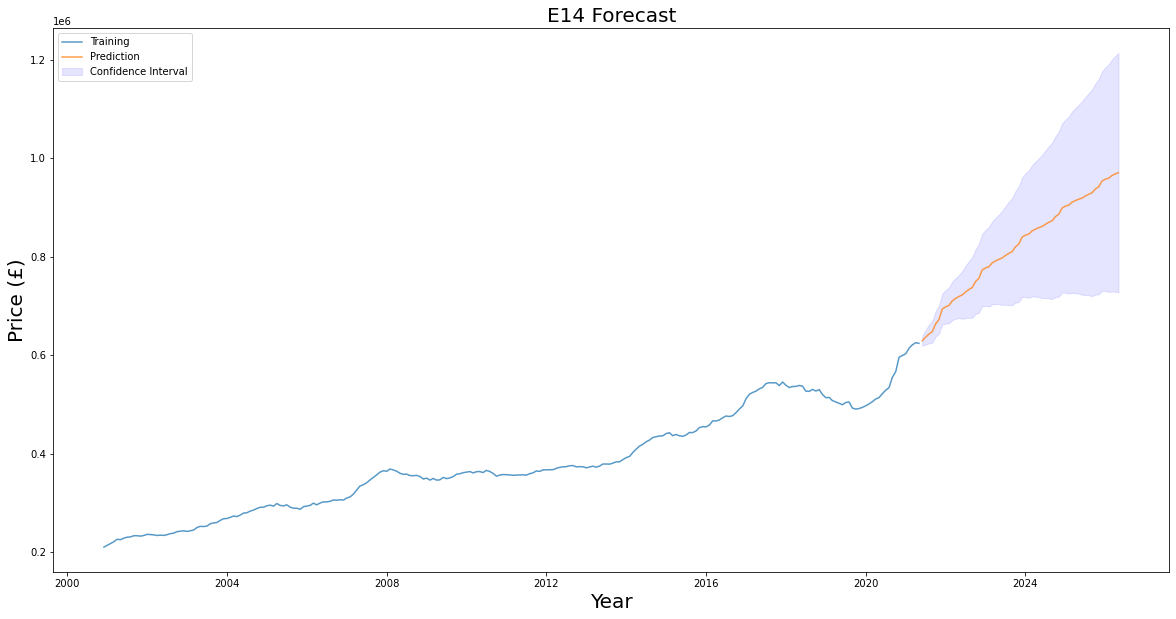

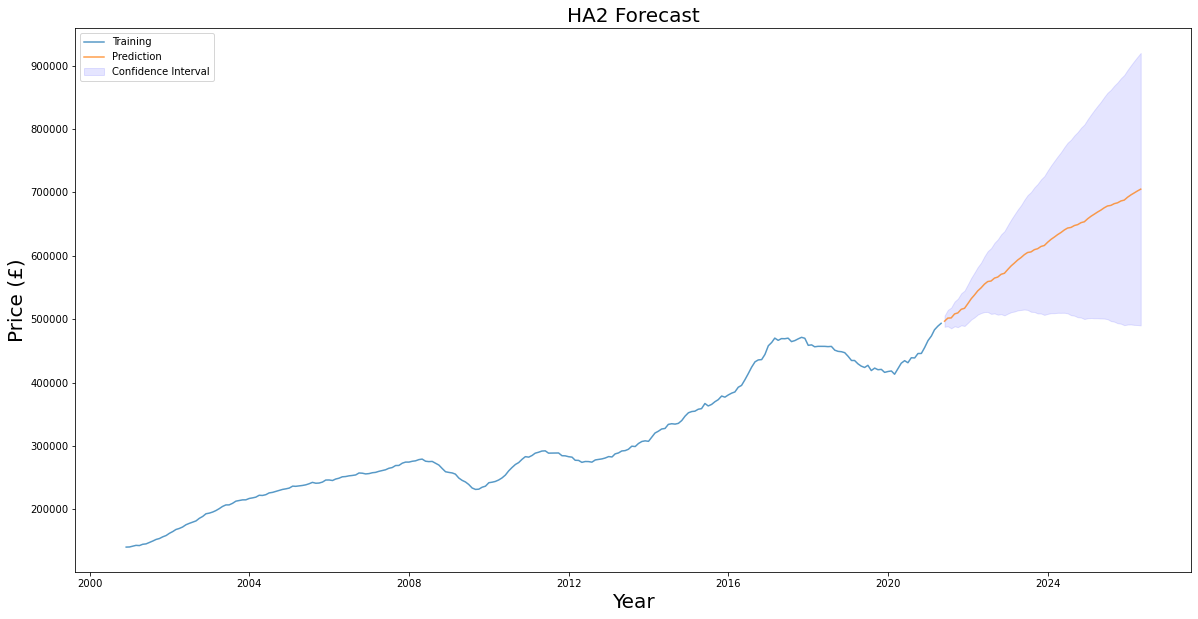

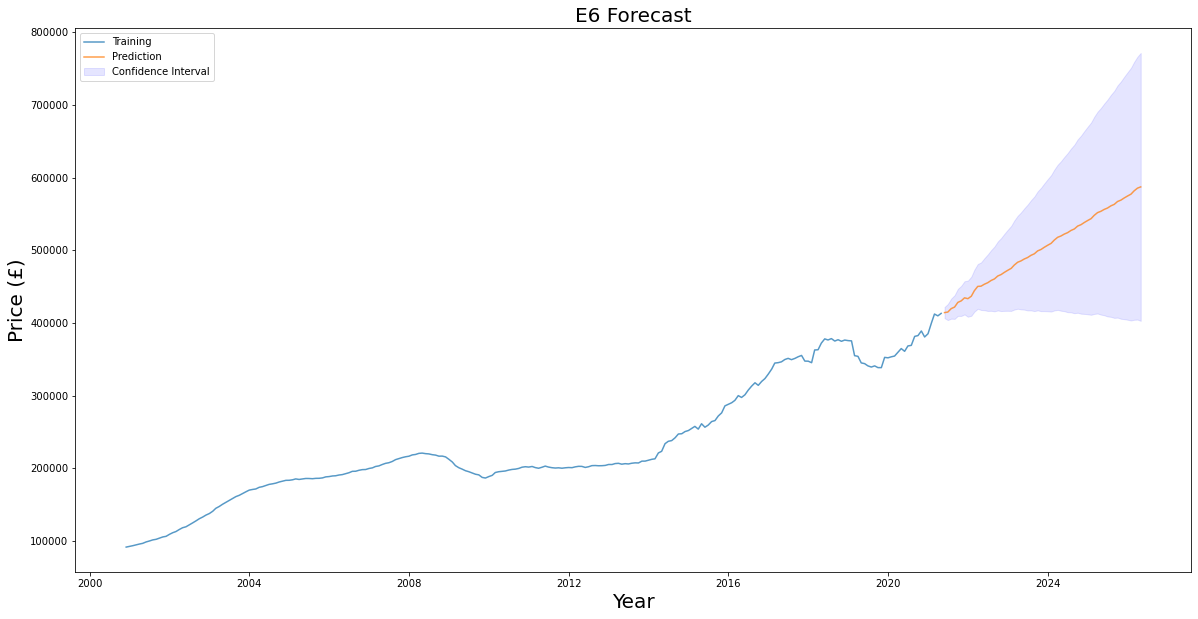

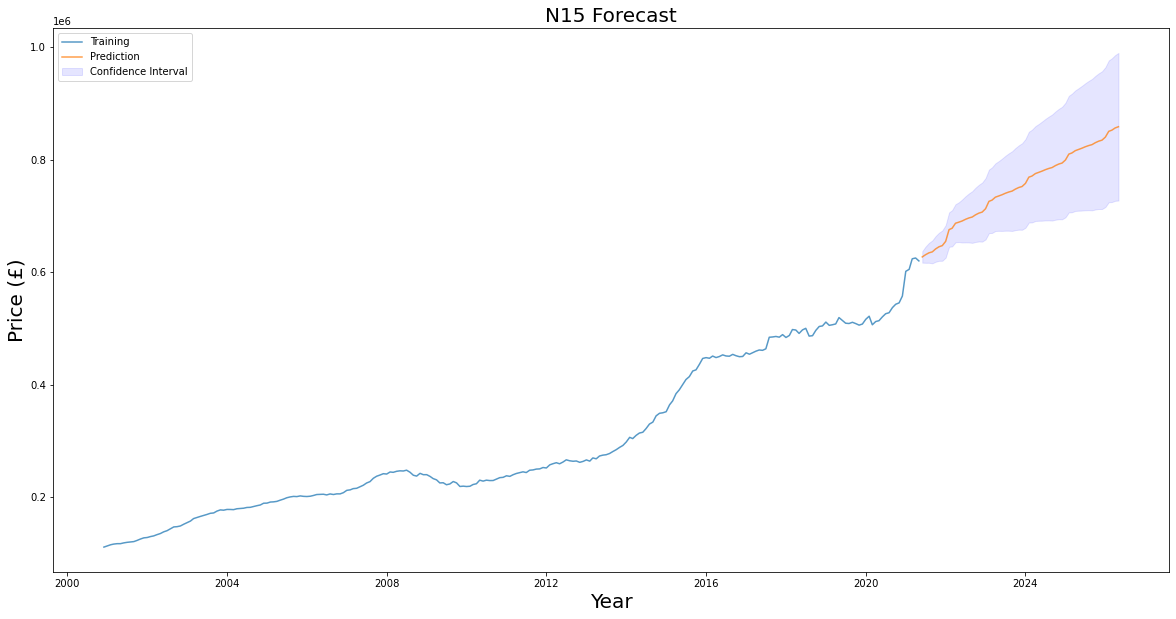

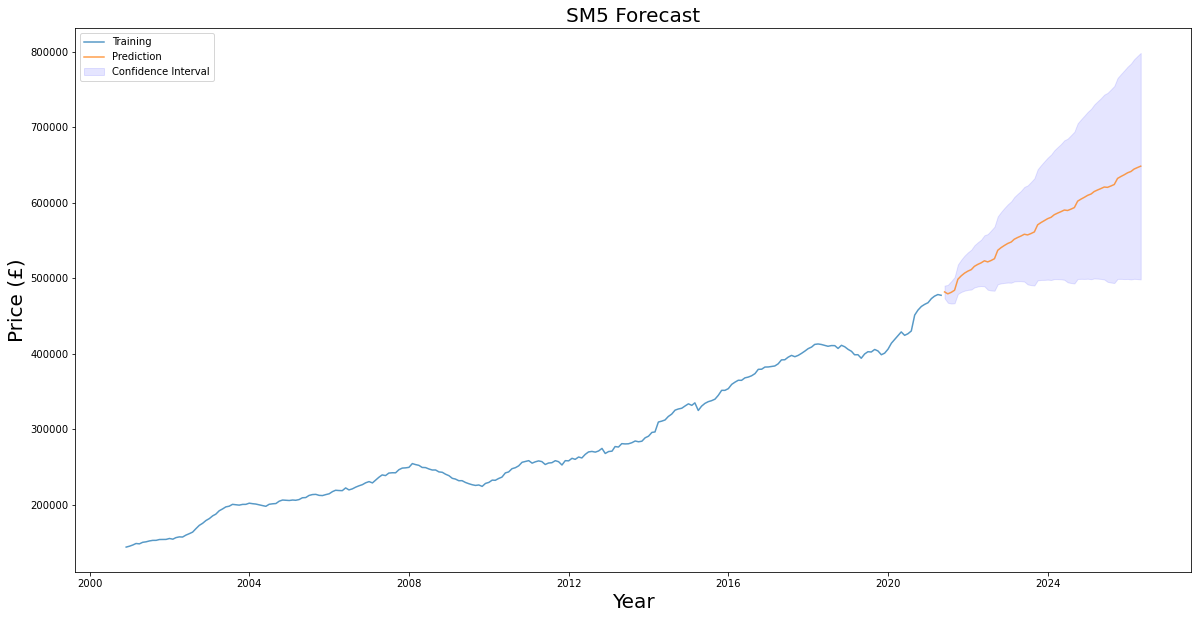

In [333]:
get_forecasts(top_5_mid)

It is not too surprising that there is some double dipping occurring here, some post codes we have seen before, but the mid case does throw up some new results.

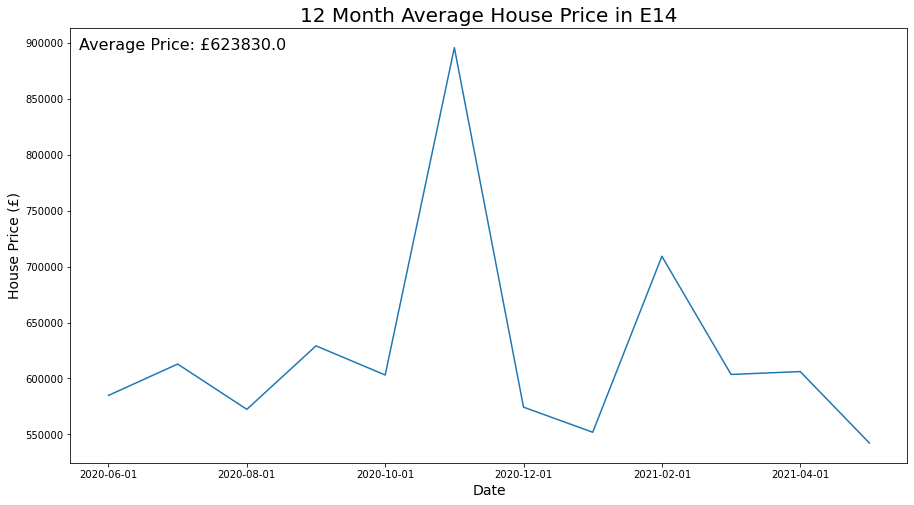

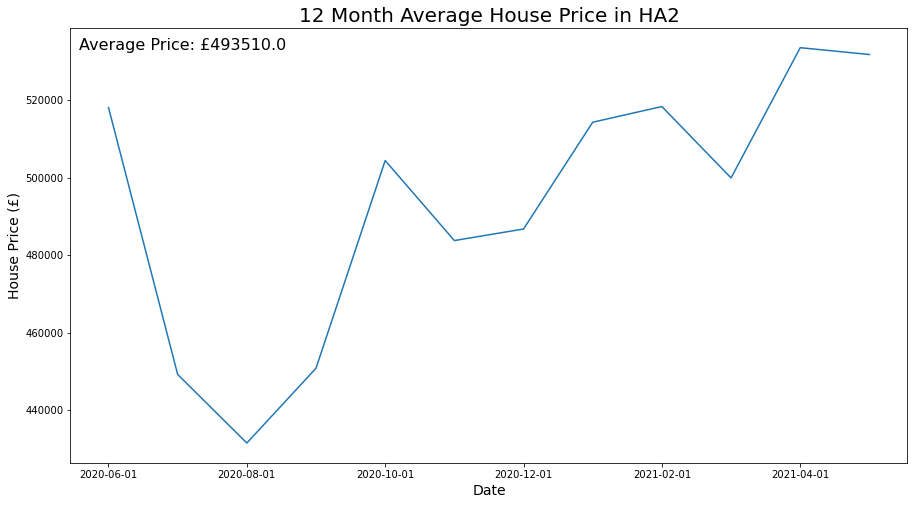

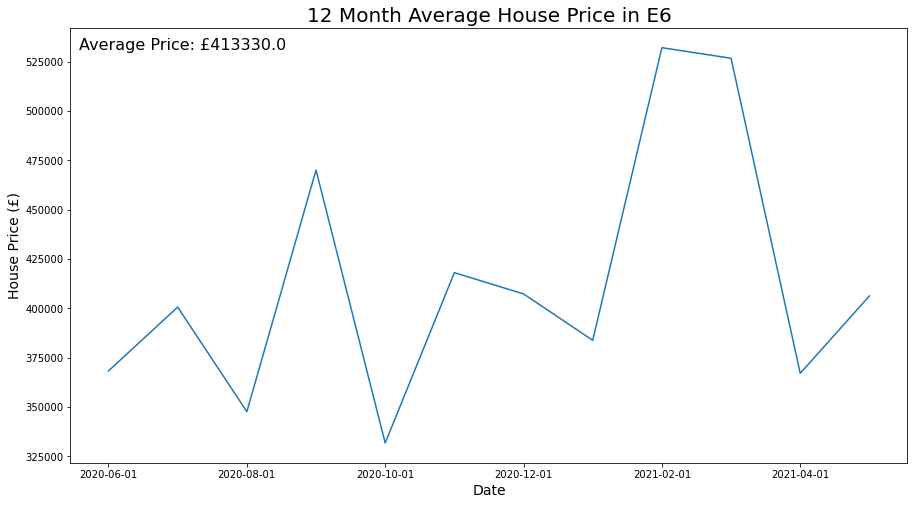

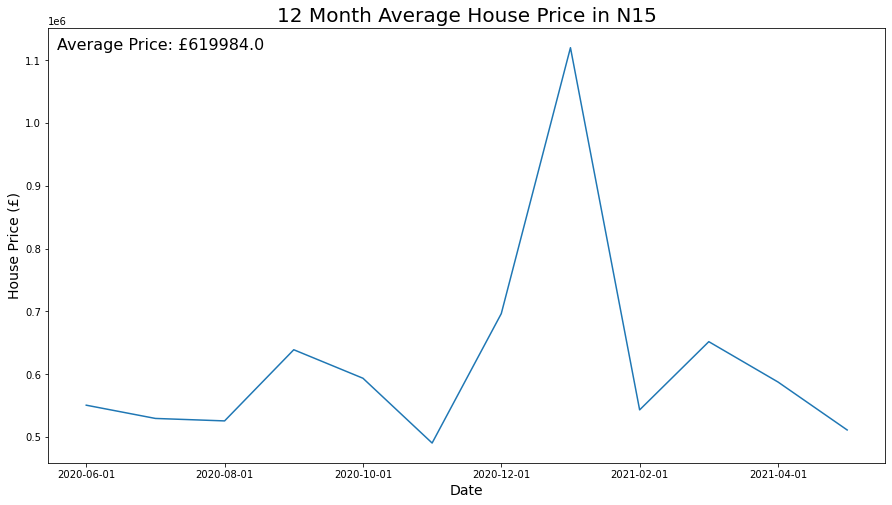

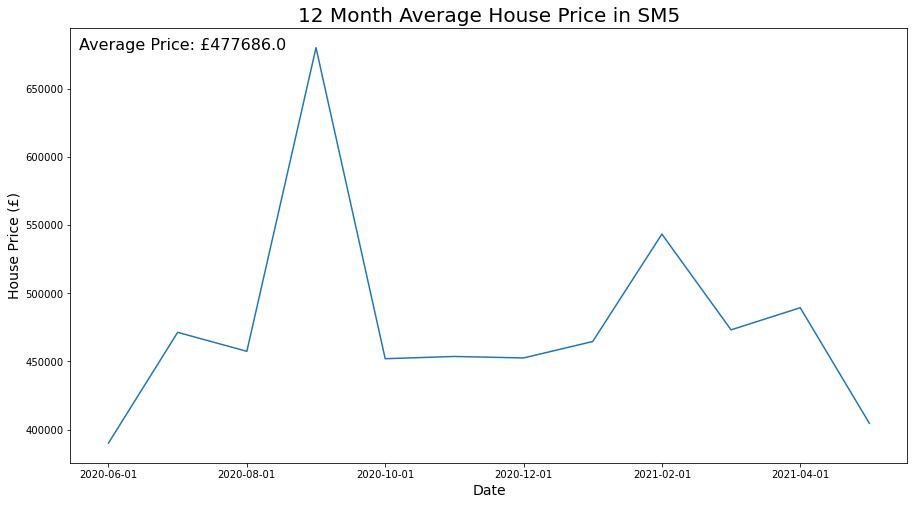

In [334]:
get_averages(df1, top_5_mid)

### High Reward

The client is chasing gains and has little concern for downsides, where would they invest?

In [335]:
top_5_high = list(summary_forecast.sort_values(by='high_ror', ascending=False).head()['Zip'].unique())

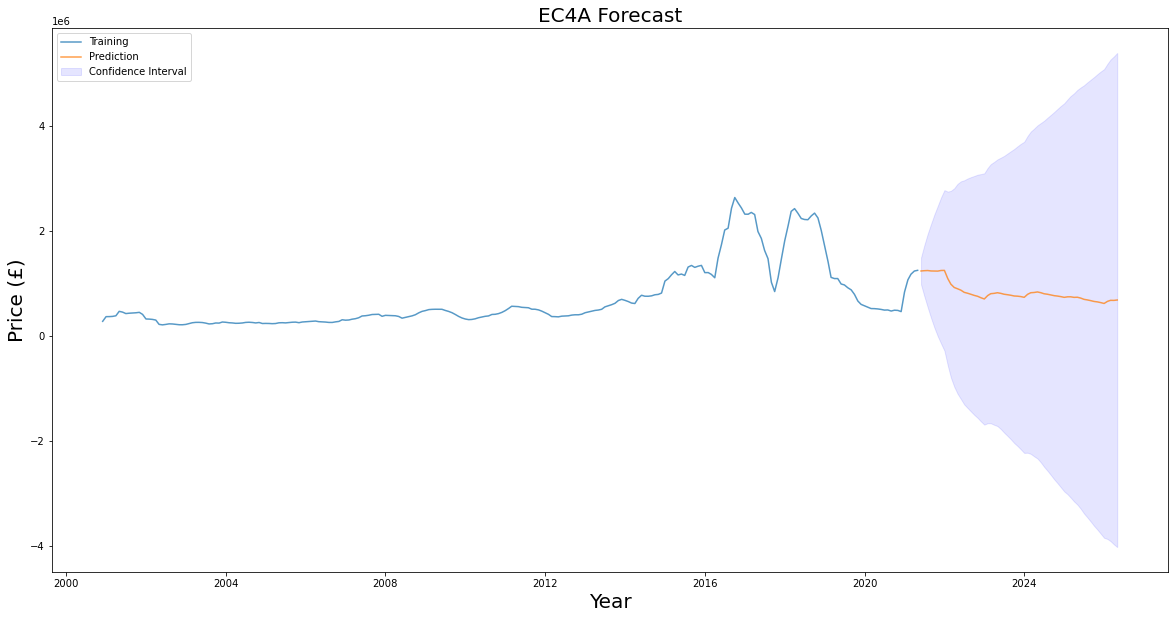

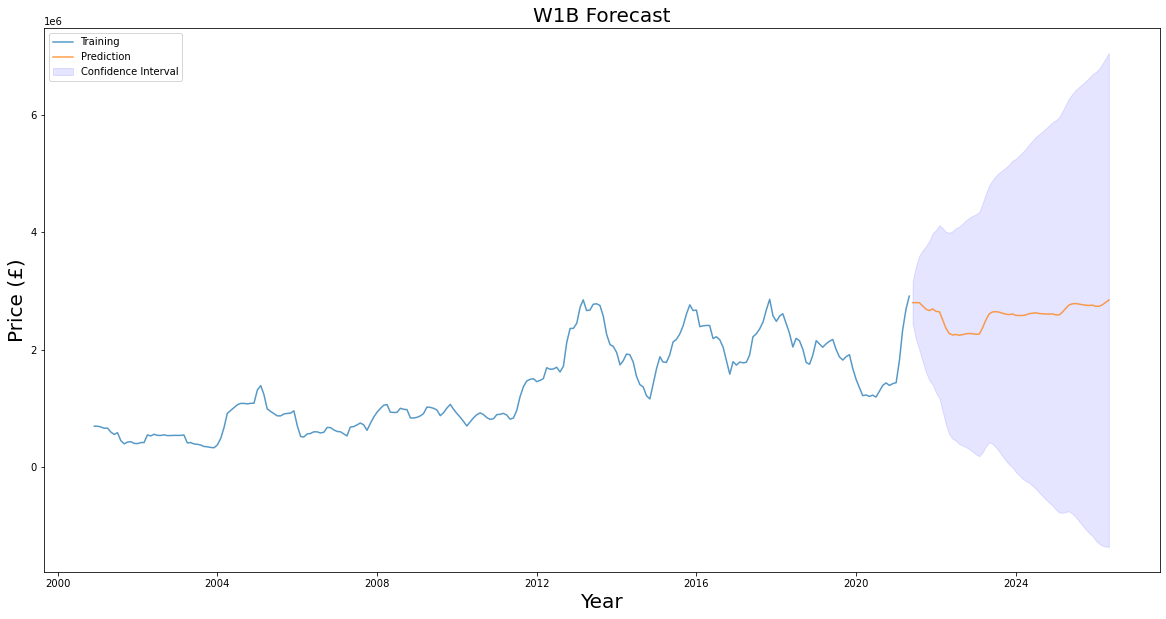

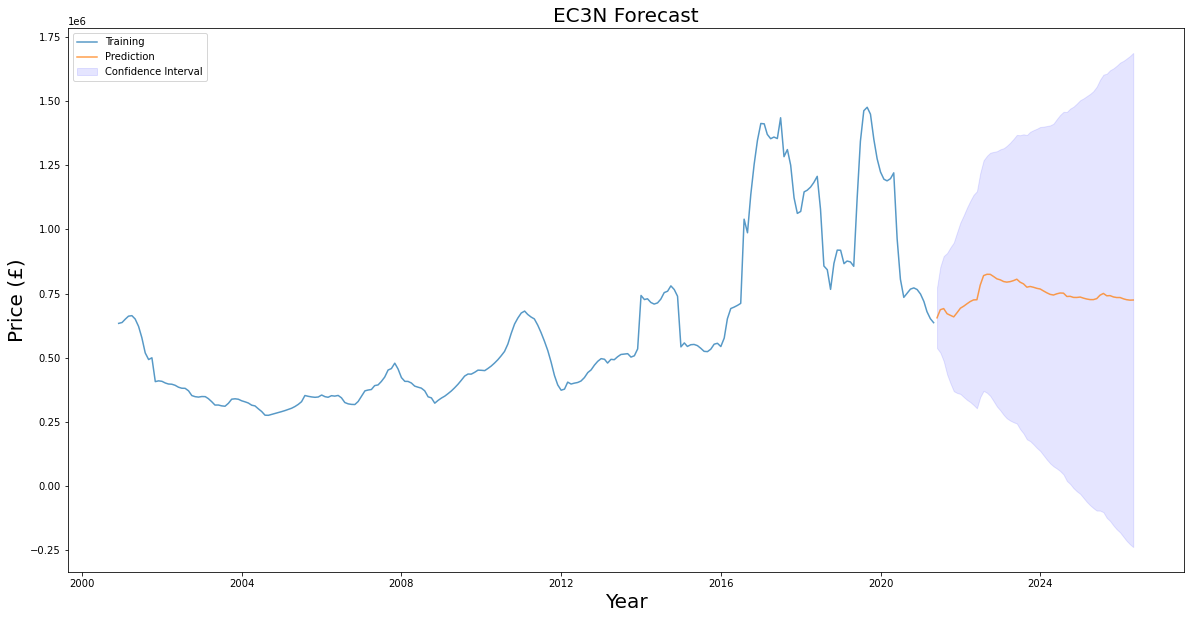

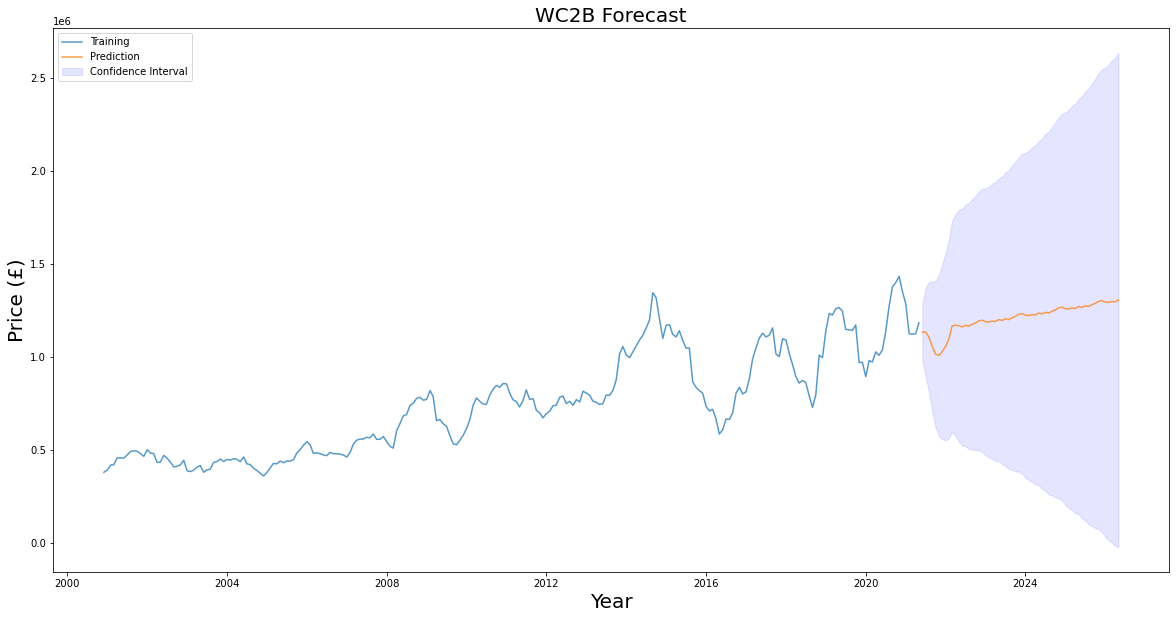

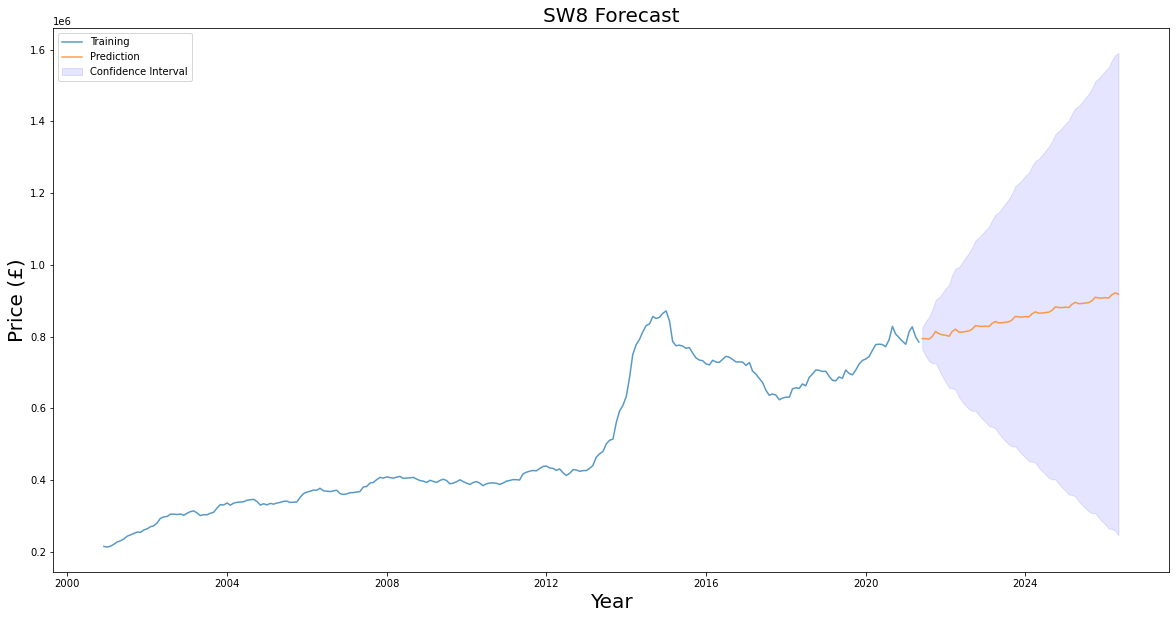

In [337]:
get_forecasts(top_5_high)

These post codes have huge upsides, but they look risky, some of the forecasts indicate the value of your property could be very low. Of course, recent events in the pandemic could be affecting the late time region of the model, this does however reflect the uncertainty in the property market which has seen particularly flats and inner city properties suffer.

In [104]:
get_df(summary_forecast, top=True)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
28   E14    727045.0    970307.0    1213569.0    17.51    54.29     89.89   
50   HA2    490236.0    705269.0     920303.0     0.46    41.96     82.02   
38    E6    403047.0    587364.0     771682.0    -0.92    41.73     82.84   
81   N15    727345.0    858583.0     989821.0    17.91    36.92     55.32   
153  SM5    498692.0    648747.0     798801.0     5.24    34.55     62.86   

             address                                           location  \
28   E14, London, UK  (London Borough of Tower Hamlets, London, Grea...   
50   HA2, London, UK  (London Borough of Harrow, London, Harrow, Gre...   
38    E6, London, UK  (E6, Quartermile Lane, Hackney Wick, London Bo...   
81   N15, London, UK  (London Borough of Haringey, London, Wood Gree...   
153  SM5, London, UK  (London Borough of Sutton, London, Carshalton,...   

      latitude  longitude  
28   51.496089  -0.016983  
50   51.566642  -0.363995  
38   51.554626  -0.019436  
81   51.589914  -0.099013  
153  51.382111  -0.176929

## Range of Model Performance

Sorting the results by SMAPE both top 5 and bottom 5 provides some context to the range of model performance. The top 5 are below:

In [124]:
get_df(merge_df, number=10, metric='SMAPE', top=False)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
139  SE26    474976.0    607414.0     739852.0    -4.68    19.05     41.70   
101   NW3   1003903.0   1606519.0    2209135.0   -26.45    14.03     52.05   
136  SE23    570028.0    743101.0     916173.0    -1.79    25.92     52.72   
40     E8    655218.0    849198.0    1043177.0    -5.49    18.88     41.85   
99   NW11    606739.0   1033145.0    1459550.0   -35.10     6.25     44.52   
2     BR3    454493.0    621889.0     789285.0   -15.42    13.71     41.84   
6     BR7    471724.0    768491.0    1065257.0   -27.66    13.72     52.31   
21    DA7    392161.0    495893.0     599625.0    -3.55    20.29     43.49   
71    KT4    442698.0    601019.0     759340.0    -9.57    20.27     48.91   
3     BR4    457046.0    698053.0     939059.0   -18.72    19.04     53.81   

              address                                           location  \
139  SE26, London, UK  (London Borough of Lewisham, London, Lewisham,...   
101   NW3, London, UK  (London Borough of Camden, London, Hampstead, ...   
136  SE23, London, UK  (London Borough of Lewisham, London, Lewisham,...   
40     E8, London, UK  (E8, Sherrin Road, New Spitalfields Market, Lo...   
99   NW11, London, UK  (NW11 38, The Ridgeway, Golders Green, London ...   
2     BR3, London, UK  (London Borough of Bromley, London, Greater Lo...   
6     BR7, London, UK  (BR7 245D, Leesons Hill, London Borough of Bro...   
21    DA7, London, UK  (DA7 138, Erith Road, Barnehurst, London Borou...   
71    KT4, London, UK  (KT4 3451;KT4 345, Cheam Common Road, Worceste...   
3     BR4, London, UK  (BR4 276, The Avenue, West Wickham, London Bor...   

      latitude  longitude     SMAPE  
139  51.427811  -0.050070  0.940318  
101  51.544321  -0.166790  1.010669  
136  51.445757  -0.048476  1.189260  
40   51.555320  -0.020843  1.259981  
99   51.571008  -0.199941  1.307112  
2    51.413148  -0.031041  1.427169  
6    51.399600   0.093538  1.455373  
21   51.460644   0.153058  1.457842  
71   51.371477  -0.228387  1.501704  
3    51.381763  -0.007623  1.509393

What does this actually look like? A symmetrical mean absolute percentage error of 0.94% to 1.5% in the top 10 is a good performance, see the Actual vs Test for Zip SE26 below:

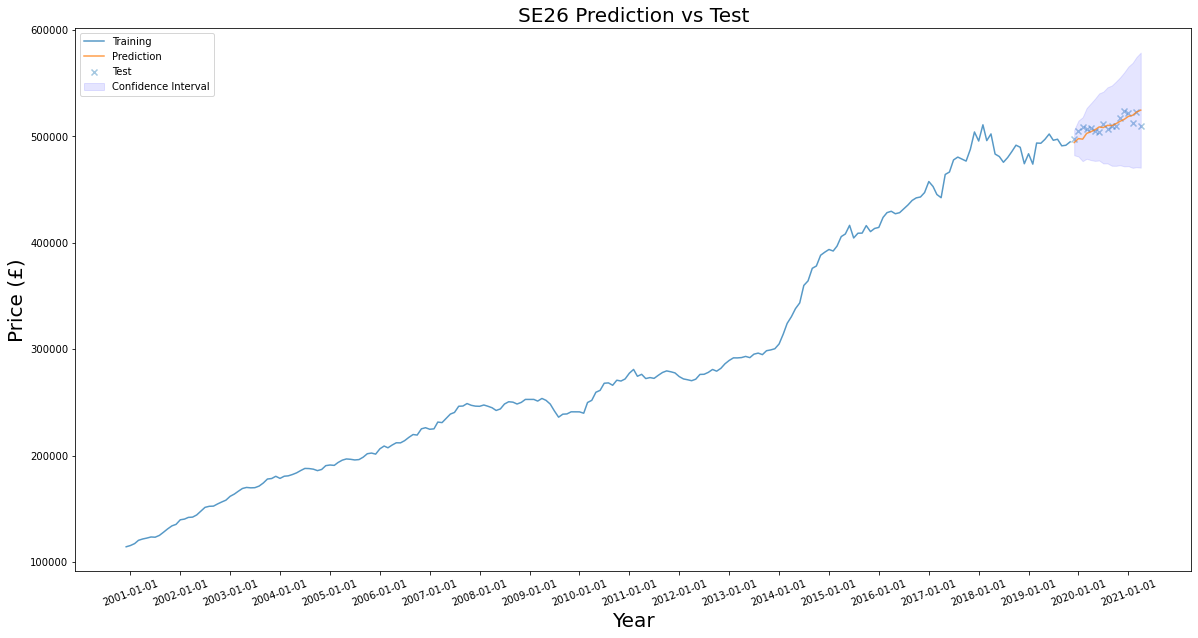

Looking at this result certainly gives more confidence in the forecast, but how about the poor performing models?

In [125]:
get_df(merge_df, number=10, metric='SMAPE', top=True)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
48   EC4A  -4022519.0    689736.0    5401990.0  -507.78   -44.52    260.12   
47   EC3N   -239224.0    724808.0    1688841.0  -144.55    10.60    118.30   
61    IG4    382112.0    645372.0     908631.0   -23.44    22.01     62.60   
203   W1B  -1361696.0   2845959.0    7053613.0  -155.77     1.60    123.17   
206   W1W   1145028.0   1620138.0    2095248.0    -6.46    23.56     49.84   
204   W1G   1074912.0   1895527.0    2716142.0   -29.19    14.32     51.06   
121   SE1    822972.0   1041191.0    1259410.0    -5.53    16.73     37.99   
186   TW5    580827.0    695112.0     809397.0     6.82    25.00     42.39   
194   UB5    201495.0    341717.0     481939.0   -32.82     8.92     47.13   
216  WC2B    -22276.0   1307569.0    2637413.0  -102.27    15.28    105.17   

              address                                           location  \
48   EC4A, London, UK  (EC4A 409;EC4A 4091, Fleet Street, Blackfriars...   
47   EC3N, London, UK                                               None   
61    IG4, London, UK  (IG4 14, Loxford Lane, Loxford, London Borough...   
203   W1B, London, UK  (W1B 236D;W1B 36D, Portland Place, Marylebone,...   
206   W1W, London, UK  (W1W 39;W1W 239, Langham Street, Fitzrovia, Ci...   
204   W1G, London, UK                                               None   
121   SE1, London, UK  (SE1, Burge Street, Walworth, London Borough o...   
186   TW5, London, UK  (TW5 44D, West Way, Heston, London Borough of ...   
194   UB5, London, UK  (London Borough of Ealing, London, Ealing, Gre...   
216  WC2B, London, UK  (WC2B 61;WC2B 261, Aldwych, St Clement Danes, ...   

      latitude  longitude      SMAPE  
48   51.514268  -0.106550  47.673540  
47         NaN        NaN  45.947878  
61   51.547130   0.081906  34.377477  
203  51.522814  -0.145960  28.783129  
206  51.519088  -0.140935  27.695673  
204        NaN        NaN  27.003986  
121  51.494724  -0.087558  23.792747  
186  51.479645  -0.380720  22.279369  
194  51.549910  -0.362897  20.627449  
216  51.513234  -0.115384  20.311786

Clearly some of these models warrant a bit more scrutiny with errors up from 20% to 45% in the worst cases, perhaps there is a reason they perform poorly and I suspect it is related to COVID-19 events

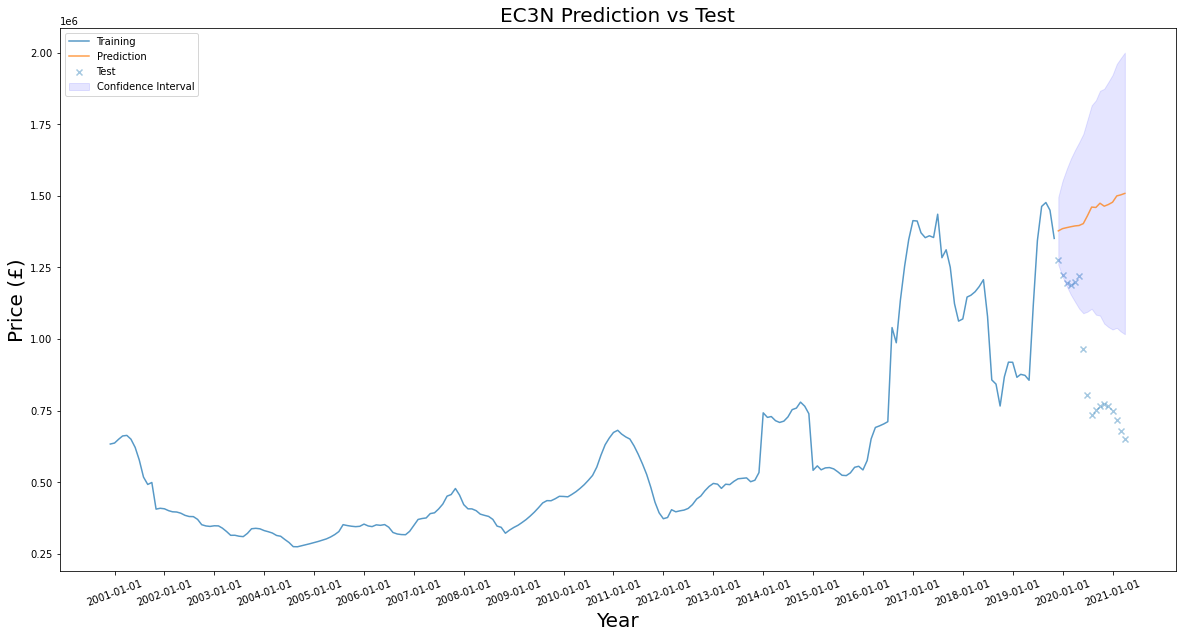

When looking at the actual data, you can see it more or less fell off the metaphorical cliff at the start of 2020 when everyone was leaving the city centres to gear up for Lockdowns. It was noted earlier, that The City of London had the fewest house sales by far and that residential purchases are relatively uncommon in these postcodes. The data sparcity could make this data set vulnerable to outliers. 

In [103]:
get_map(get_df(summary_forecast, top=False))

In [126]:
get_map(summary_forecast)

# Conclusion

- Central and Expensive Boroughs seem to be subject to biggest fluctuations in price
- 4 of the top 5 postcodes with the highest rate of returns are outside what would be considered Central London





In [120]:
get_df(merge_df)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
28   E14    727045.0    970307.0    1213569.0    17.51    54.29     89.89   
50   HA2    490236.0    705269.0     920303.0     0.46    41.96     82.02   
38    E6    403047.0    587364.0     771682.0    -0.92    41.73     82.84   
81   N15    727345.0    858583.0     989821.0    17.91    36.92     55.32   
153  SM5    498692.0    648747.0     798801.0     5.24    34.55     62.86   

             address                                           location  \
28   E14, London, UK  (London Borough of Tower Hamlets, London, Grea...   
50   HA2, London, UK  (London Borough of Harrow, London, Harrow, Gre...   
38    E6, London, UK  (E6, Quartermile Lane, Hackney Wick, London Bo...   
81   N15, London, UK  (London Borough of Haringey, London, Wood Gree...   
153  SM5, London, UK  (London Borough of Sutton, London, Carshalton,...   

      latitude  longitude      SMAPE  
28   51.496089  -0.016983  15.882761  
50   51.566642  -0.363995   8.039662  
38   51.554626  -0.019436  15.477474  
81   51.589914  -0.099013   5.024072  
153  51.382111  -0.176929  10.959178

- 4 of the bottom 5 postcodes for rate of return are in central areas and/or close to financial hubs (The City of London or Canary Wharf)



In [121]:
get_df(merge_df, top=False)

Zip  5_year_Low  5_year_mid  5_year_high  low_ror  mid_ror  high_ror  \
48   EC4A  -4022519.0    689736.0    5401990.0  -507.78   -44.52    260.12   
68   KT17   -356484.0    438343.0    1233169.0  -158.12   -30.81     88.64   
23     E1    258143.0    490705.0     723267.0   -52.88   -13.40     23.53   
122  SE10    237681.0    548284.0     858887.0   -57.48    -4.75     45.02   
165  SW1P    354206.0    869200.0    1384194.0   -58.68    -4.34     44.17   

              address                                           location  \
48   EC4A, London, UK  (EC4A 409;EC4A 4091, Fleet Street, Blackfriars...   
68   KT17, London, UK  (KT17 6, London Road, Stoneleigh, Ewell, Epsom...   
23     E1, London, UK  (E1, Airside Road Tunnel, London Borough of Hi...   
122  SE10, London, UK  (Royal Borough of Greenwich, London, Eltham, G...   
165  SW1P, London, UK  (SW1P 33;SW1P 133, Dean's Yard, Westminster, C...   

      latitude  longitude      SMAPE  
48   51.514268  -0.106550  47.673540  
68   51.355890  -0.242909  10.375484  
23   51.468002  -0.468630  10.416601  
122  51.483057  -0.001199   6.010099  
165  51.498972  -0.128953   9.062039

There have been multiple things that have occurred in 2020 and 2021 which make house price forecasting challenging so it may be worth filtering the results so the SMAPE is within a certain threshold and provides more confidence in results.
Firstly COVID-19 pandemic and its impact on people's working routines and their desire for more space.
Secondly the government introduced a Stamp Duty (Tax) holiday which, whilst saving money on taxes, actually raised asking prices of homes as there was a mad panic to purchase before this stamp duty holiday ended. 

Forecasting the rolling average with 12 month window helped smooth out some of these trends, but for events that last longer than one year like COVID-19 has, it can be problematic for forecasting.

As time series modelling is so sensitive to recent data, it is imperative that these models be updated regularly (at least quarterly) with recent data to ensure modelling errors remain small. 

It may be useful to introduce some exogenous data into the models:
- Bank of England interest rates
- COVID-19 infection rates
- Lockdown events
- Number of people returning to office work